# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [87]:
data_dir = '/'
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

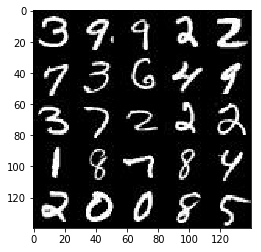

In [88]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

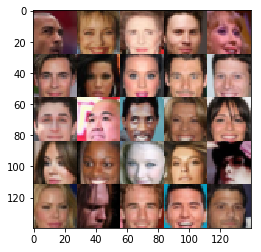

In [89]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [90]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [91]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32, shape=())
    return images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [92]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        d1 = tf.nn.dropout(relu1, keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        d2 = tf.nn.dropout(relu2, keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        d3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(d3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        # using valid padding and stride 1 to get size of 7 instead of 8
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x2a = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2a = tf.layers.batch_normalization(x2a, training=is_train)
        x2a = tf.maximum(alpha * x2a, x2a)
        # one more 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2a, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [94]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [95]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [97]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if batch_i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, batch {}...".format(epoch_i + 1, epoch_count, batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if batch_i % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, batch 0... Discriminator Loss: 9.1441... Generator Loss: 0.0003


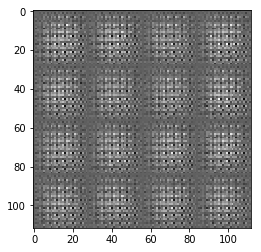

Epoch 1/2, batch 10... Discriminator Loss: 3.1703... Generator Loss: 0.5977
Epoch 1/2, batch 20... Discriminator Loss: 3.0857... Generator Loss: 0.0748
Epoch 1/2, batch 30... Discriminator Loss: 1.8313... Generator Loss: 1.4853
Epoch 1/2, batch 40... Discriminator Loss: 1.6704... Generator Loss: 1.4134
Epoch 1/2, batch 50... Discriminator Loss: 2.1404... Generator Loss: 0.6451
Epoch 1/2, batch 60... Discriminator Loss: 2.0073... Generator Loss: 0.4250
Epoch 1/2, batch 70... Discriminator Loss: 2.6584... Generator Loss: 0.2325
Epoch 1/2, batch 80... Discriminator Loss: 1.8411... Generator Loss: 0.6385
Epoch 1/2, batch 90... Discriminator Loss: 1.8939... Generator Loss: 0.5770
Epoch 1/2, batch 100... Discriminator Loss: 1.6446... Generator Loss: 0.6098


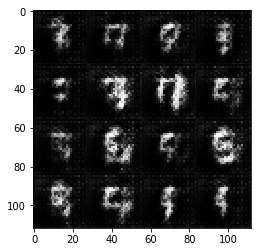

Epoch 1/2, batch 110... Discriminator Loss: 2.1288... Generator Loss: 0.3716
Epoch 1/2, batch 120... Discriminator Loss: 1.6919... Generator Loss: 0.6354
Epoch 1/2, batch 130... Discriminator Loss: 1.7267... Generator Loss: 0.6925
Epoch 1/2, batch 140... Discriminator Loss: 1.7782... Generator Loss: 0.3767
Epoch 1/2, batch 150... Discriminator Loss: 1.7654... Generator Loss: 0.3780
Epoch 1/2, batch 160... Discriminator Loss: 1.7352... Generator Loss: 0.7338
Epoch 1/2, batch 170... Discriminator Loss: 1.5365... Generator Loss: 0.9689
Epoch 1/2, batch 180... Discriminator Loss: 1.5739... Generator Loss: 0.5317
Epoch 1/2, batch 190... Discriminator Loss: 1.6539... Generator Loss: 0.5133
Epoch 1/2, batch 200... Discriminator Loss: 1.5909... Generator Loss: 0.5636


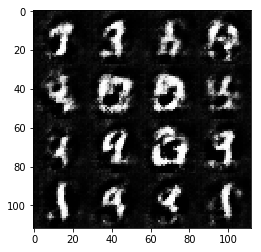

Epoch 1/2, batch 210... Discriminator Loss: 1.6901... Generator Loss: 0.6580
Epoch 1/2, batch 220... Discriminator Loss: 1.4519... Generator Loss: 0.7817
Epoch 1/2, batch 230... Discriminator Loss: 1.7155... Generator Loss: 0.7771
Epoch 1/2, batch 240... Discriminator Loss: 1.7625... Generator Loss: 0.4229
Epoch 1/2, batch 250... Discriminator Loss: 1.8093... Generator Loss: 0.3662
Epoch 1/2, batch 260... Discriminator Loss: 1.5733... Generator Loss: 0.6780
Epoch 1/2, batch 270... Discriminator Loss: 1.5006... Generator Loss: 0.5916
Epoch 1/2, batch 280... Discriminator Loss: 1.6265... Generator Loss: 0.5171
Epoch 1/2, batch 290... Discriminator Loss: 1.6861... Generator Loss: 0.3412
Epoch 1/2, batch 300... Discriminator Loss: 1.5885... Generator Loss: 0.8684


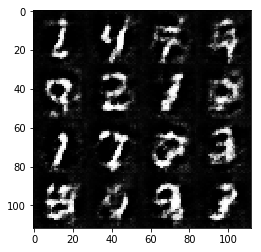

Epoch 1/2, batch 310... Discriminator Loss: 1.5433... Generator Loss: 0.7663
Epoch 1/2, batch 320... Discriminator Loss: 1.7591... Generator Loss: 0.3484
Epoch 1/2, batch 330... Discriminator Loss: 1.6951... Generator Loss: 0.4582
Epoch 1/2, batch 340... Discriminator Loss: 1.5330... Generator Loss: 0.5843
Epoch 1/2, batch 350... Discriminator Loss: 1.5412... Generator Loss: 0.5413
Epoch 1/2, batch 360... Discriminator Loss: 1.5728... Generator Loss: 0.5612
Epoch 1/2, batch 370... Discriminator Loss: 1.6054... Generator Loss: 0.5627
Epoch 1/2, batch 380... Discriminator Loss: 1.4866... Generator Loss: 0.7401
Epoch 1/2, batch 390... Discriminator Loss: 1.5733... Generator Loss: 0.5349
Epoch 1/2, batch 400... Discriminator Loss: 1.5604... Generator Loss: 0.6321


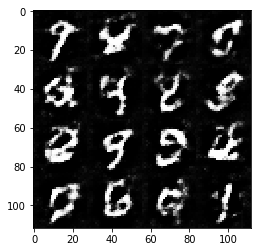

Epoch 1/2, batch 410... Discriminator Loss: 1.6385... Generator Loss: 0.4403
Epoch 1/2, batch 420... Discriminator Loss: 1.5897... Generator Loss: 0.4885
Epoch 1/2, batch 430... Discriminator Loss: 1.6272... Generator Loss: 0.6428
Epoch 1/2, batch 440... Discriminator Loss: 1.5516... Generator Loss: 0.4633
Epoch 1/2, batch 450... Discriminator Loss: 1.4124... Generator Loss: 0.6571
Epoch 1/2, batch 460... Discriminator Loss: 1.5660... Generator Loss: 0.6832
Epoch 1/2, batch 470... Discriminator Loss: 1.6357... Generator Loss: 0.9428
Epoch 1/2, batch 480... Discriminator Loss: 1.5823... Generator Loss: 0.7742
Epoch 1/2, batch 490... Discriminator Loss: 1.4599... Generator Loss: 0.8161
Epoch 1/2, batch 500... Discriminator Loss: 1.5212... Generator Loss: 1.0023


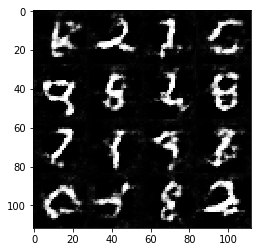

Epoch 1/2, batch 510... Discriminator Loss: 1.6573... Generator Loss: 0.4299
Epoch 1/2, batch 520... Discriminator Loss: 1.5236... Generator Loss: 0.7033
Epoch 1/2, batch 530... Discriminator Loss: 1.6203... Generator Loss: 0.5018
Epoch 1/2, batch 540... Discriminator Loss: 1.5708... Generator Loss: 0.8991
Epoch 1/2, batch 550... Discriminator Loss: 1.5295... Generator Loss: 0.7572
Epoch 1/2, batch 560... Discriminator Loss: 1.5387... Generator Loss: 0.7276
Epoch 1/2, batch 570... Discriminator Loss: 1.4870... Generator Loss: 0.7436
Epoch 1/2, batch 580... Discriminator Loss: 1.4734... Generator Loss: 0.8182
Epoch 1/2, batch 590... Discriminator Loss: 1.5897... Generator Loss: 0.6082
Epoch 1/2, batch 600... Discriminator Loss: 1.4688... Generator Loss: 0.7062


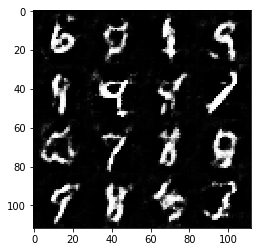

Epoch 1/2, batch 610... Discriminator Loss: 1.4965... Generator Loss: 0.6652
Epoch 1/2, batch 620... Discriminator Loss: 1.4591... Generator Loss: 0.7810
Epoch 1/2, batch 630... Discriminator Loss: 1.5136... Generator Loss: 0.7396
Epoch 1/2, batch 640... Discriminator Loss: 1.4157... Generator Loss: 0.9141
Epoch 1/2, batch 650... Discriminator Loss: 1.5489... Generator Loss: 0.9344
Epoch 1/2, batch 660... Discriminator Loss: 1.5580... Generator Loss: 0.5343
Epoch 1/2, batch 670... Discriminator Loss: 1.4579... Generator Loss: 0.9235
Epoch 1/2, batch 680... Discriminator Loss: 1.4483... Generator Loss: 0.7727
Epoch 1/2, batch 690... Discriminator Loss: 1.5358... Generator Loss: 0.7772
Epoch 1/2, batch 700... Discriminator Loss: 1.4836... Generator Loss: 0.9586


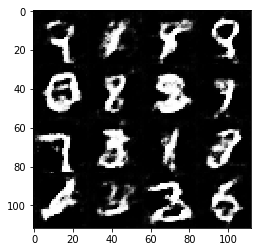

Epoch 1/2, batch 710... Discriminator Loss: 1.4773... Generator Loss: 0.7412
Epoch 1/2, batch 720... Discriminator Loss: 1.5279... Generator Loss: 0.7500
Epoch 1/2, batch 730... Discriminator Loss: 1.5667... Generator Loss: 0.7443
Epoch 1/2, batch 740... Discriminator Loss: 1.4521... Generator Loss: 0.6380
Epoch 1/2, batch 750... Discriminator Loss: 1.3936... Generator Loss: 0.5435
Epoch 1/2, batch 760... Discriminator Loss: 1.4530... Generator Loss: 0.6391
Epoch 1/2, batch 770... Discriminator Loss: 1.4362... Generator Loss: 0.6084
Epoch 1/2, batch 780... Discriminator Loss: 1.5680... Generator Loss: 0.7237
Epoch 1/2, batch 790... Discriminator Loss: 1.4965... Generator Loss: 0.5236
Epoch 1/2, batch 800... Discriminator Loss: 1.4181... Generator Loss: 0.6295


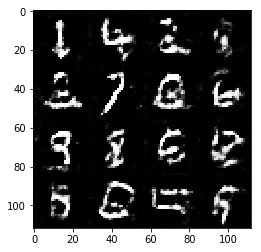

Epoch 1/2, batch 810... Discriminator Loss: 1.4982... Generator Loss: 0.7041
Epoch 1/2, batch 820... Discriminator Loss: 1.4653... Generator Loss: 0.7664
Epoch 1/2, batch 830... Discriminator Loss: 1.5265... Generator Loss: 0.4082
Epoch 1/2, batch 840... Discriminator Loss: 1.3657... Generator Loss: 0.8507
Epoch 1/2, batch 850... Discriminator Loss: 1.4253... Generator Loss: 0.5536
Epoch 1/2, batch 860... Discriminator Loss: 1.5090... Generator Loss: 0.5136
Epoch 1/2, batch 870... Discriminator Loss: 1.4481... Generator Loss: 0.6037
Epoch 1/2, batch 880... Discriminator Loss: 1.5982... Generator Loss: 0.5052
Epoch 1/2, batch 890... Discriminator Loss: 1.3971... Generator Loss: 0.7081
Epoch 1/2, batch 900... Discriminator Loss: 1.4224... Generator Loss: 0.6796


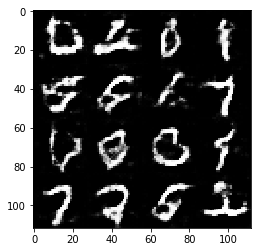

Epoch 1/2, batch 910... Discriminator Loss: 1.5792... Generator Loss: 0.8969
Epoch 1/2, batch 920... Discriminator Loss: 1.5249... Generator Loss: 0.7213
Epoch 1/2, batch 930... Discriminator Loss: 1.4319... Generator Loss: 0.6801
Epoch 1/2, batch 940... Discriminator Loss: 1.5886... Generator Loss: 1.0761
Epoch 1/2, batch 950... Discriminator Loss: 1.4898... Generator Loss: 0.5986
Epoch 1/2, batch 960... Discriminator Loss: 1.5296... Generator Loss: 0.8547
Epoch 1/2, batch 970... Discriminator Loss: 1.4732... Generator Loss: 0.7988
Epoch 1/2, batch 980... Discriminator Loss: 1.4845... Generator Loss: 0.7046
Epoch 1/2, batch 990... Discriminator Loss: 1.4986... Generator Loss: 0.7226
Epoch 1/2, batch 1000... Discriminator Loss: 1.4852... Generator Loss: 0.6199


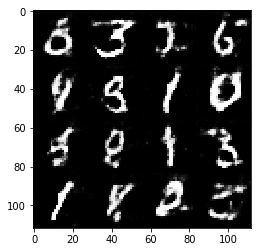

Epoch 1/2, batch 1010... Discriminator Loss: 1.3655... Generator Loss: 0.8021
Epoch 1/2, batch 1020... Discriminator Loss: 1.4038... Generator Loss: 0.9366
Epoch 1/2, batch 1030... Discriminator Loss: 1.7794... Generator Loss: 1.2400
Epoch 1/2, batch 1040... Discriminator Loss: 1.4814... Generator Loss: 0.6421
Epoch 1/2, batch 1050... Discriminator Loss: 1.4817... Generator Loss: 0.6871
Epoch 1/2, batch 1060... Discriminator Loss: 1.4910... Generator Loss: 0.5870
Epoch 1/2, batch 1070... Discriminator Loss: 1.6762... Generator Loss: 0.4108
Epoch 1/2, batch 1080... Discriminator Loss: 1.4348... Generator Loss: 0.5886
Epoch 1/2, batch 1090... Discriminator Loss: 1.4330... Generator Loss: 0.6317
Epoch 1/2, batch 1100... Discriminator Loss: 1.5451... Generator Loss: 0.5976


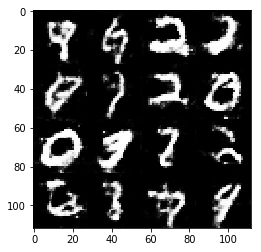

Epoch 1/2, batch 1110... Discriminator Loss: 1.5359... Generator Loss: 1.0712
Epoch 1/2, batch 1120... Discriminator Loss: 1.4048... Generator Loss: 0.8429
Epoch 1/2, batch 1130... Discriminator Loss: 1.4377... Generator Loss: 0.9008
Epoch 1/2, batch 1140... Discriminator Loss: 1.7016... Generator Loss: 0.3624
Epoch 1/2, batch 1150... Discriminator Loss: 1.4718... Generator Loss: 0.6791
Epoch 1/2, batch 1160... Discriminator Loss: 1.6084... Generator Loss: 1.2569
Epoch 1/2, batch 1170... Discriminator Loss: 1.3489... Generator Loss: 0.6300
Epoch 1/2, batch 1180... Discriminator Loss: 1.4849... Generator Loss: 0.6349
Epoch 1/2, batch 1190... Discriminator Loss: 1.6329... Generator Loss: 1.1580
Epoch 1/2, batch 1200... Discriminator Loss: 1.4228... Generator Loss: 0.7069


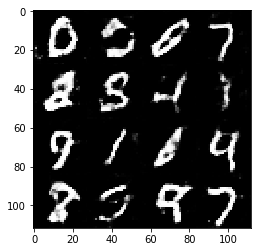

Epoch 1/2, batch 1210... Discriminator Loss: 1.5596... Generator Loss: 0.7021
Epoch 1/2, batch 1220... Discriminator Loss: 1.4737... Generator Loss: 0.6933
Epoch 1/2, batch 1230... Discriminator Loss: 1.3757... Generator Loss: 0.6669
Epoch 1/2, batch 1240... Discriminator Loss: 1.4831... Generator Loss: 0.5936
Epoch 1/2, batch 1250... Discriminator Loss: 1.4373... Generator Loss: 0.7699
Epoch 1/2, batch 1260... Discriminator Loss: 1.6130... Generator Loss: 0.4529
Epoch 1/2, batch 1270... Discriminator Loss: 2.1310... Generator Loss: 0.1925
Epoch 1/2, batch 1280... Discriminator Loss: 1.5016... Generator Loss: 0.7160
Epoch 1/2, batch 1290... Discriminator Loss: 1.4768... Generator Loss: 0.6580
Epoch 1/2, batch 1300... Discriminator Loss: 1.3546... Generator Loss: 0.6937


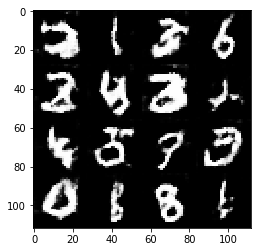

Epoch 1/2, batch 1310... Discriminator Loss: 1.5768... Generator Loss: 0.6344
Epoch 1/2, batch 1320... Discriminator Loss: 1.4904... Generator Loss: 0.7774
Epoch 1/2, batch 1330... Discriminator Loss: 1.5243... Generator Loss: 0.7217
Epoch 1/2, batch 1340... Discriminator Loss: 1.3984... Generator Loss: 0.5346
Epoch 1/2, batch 1350... Discriminator Loss: 1.4656... Generator Loss: 0.7070
Epoch 1/2, batch 1360... Discriminator Loss: 1.3804... Generator Loss: 0.7428
Epoch 1/2, batch 1370... Discriminator Loss: 2.1515... Generator Loss: 0.1984
Epoch 1/2, batch 1380... Discriminator Loss: 1.5074... Generator Loss: 0.6205
Epoch 1/2, batch 1390... Discriminator Loss: 1.4828... Generator Loss: 0.6106
Epoch 1/2, batch 1400... Discriminator Loss: 1.3943... Generator Loss: 0.9485


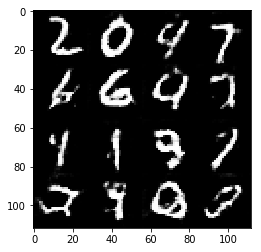

Epoch 1/2, batch 1410... Discriminator Loss: 1.4403... Generator Loss: 0.7164
Epoch 1/2, batch 1420... Discriminator Loss: 1.5150... Generator Loss: 0.8855
Epoch 1/2, batch 1430... Discriminator Loss: 1.4354... Generator Loss: 0.7205
Epoch 1/2, batch 1440... Discriminator Loss: 1.4415... Generator Loss: 0.9782
Epoch 1/2, batch 1450... Discriminator Loss: 1.3617... Generator Loss: 1.0953
Epoch 1/2, batch 1460... Discriminator Loss: 1.6177... Generator Loss: 0.3925
Epoch 1/2, batch 1470... Discriminator Loss: 1.4269... Generator Loss: 0.6783
Epoch 1/2, batch 1480... Discriminator Loss: 1.3298... Generator Loss: 0.6380
Epoch 1/2, batch 1490... Discriminator Loss: 1.5435... Generator Loss: 0.5442
Epoch 1/2, batch 1500... Discriminator Loss: 1.3169... Generator Loss: 0.6999


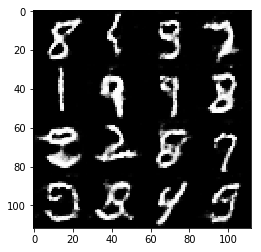

Epoch 1/2, batch 1510... Discriminator Loss: 2.6274... Generator Loss: 2.2962
Epoch 1/2, batch 1520... Discriminator Loss: 1.4466... Generator Loss: 0.7932
Epoch 1/2, batch 1530... Discriminator Loss: 1.4157... Generator Loss: 0.7476
Epoch 1/2, batch 1540... Discriminator Loss: 1.4347... Generator Loss: 0.9158
Epoch 1/2, batch 1550... Discriminator Loss: 1.3428... Generator Loss: 0.7000
Epoch 1/2, batch 1560... Discriminator Loss: 1.4420... Generator Loss: 0.6160
Epoch 1/2, batch 1570... Discriminator Loss: 1.2589... Generator Loss: 0.7005
Epoch 1/2, batch 1580... Discriminator Loss: 1.4785... Generator Loss: 0.7436
Epoch 1/2, batch 1590... Discriminator Loss: 1.4165... Generator Loss: 0.8033
Epoch 1/2, batch 1600... Discriminator Loss: 1.5599... Generator Loss: 1.0817


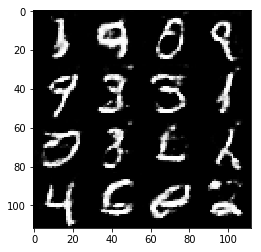

Epoch 1/2, batch 1610... Discriminator Loss: 1.5496... Generator Loss: 0.7055
Epoch 1/2, batch 1620... Discriminator Loss: 1.3156... Generator Loss: 0.7669
Epoch 1/2, batch 1630... Discriminator Loss: 1.6075... Generator Loss: 0.4780
Epoch 1/2, batch 1640... Discriminator Loss: 1.4403... Generator Loss: 0.5870
Epoch 1/2, batch 1650... Discriminator Loss: 1.7300... Generator Loss: 0.3280
Epoch 1/2, batch 1660... Discriminator Loss: 1.3816... Generator Loss: 0.7833
Epoch 1/2, batch 1670... Discriminator Loss: 1.4168... Generator Loss: 1.0113
Epoch 1/2, batch 1680... Discriminator Loss: 1.4217... Generator Loss: 0.6670
Epoch 1/2, batch 1690... Discriminator Loss: 2.0071... Generator Loss: 0.2330
Epoch 1/2, batch 1700... Discriminator Loss: 1.4210... Generator Loss: 0.5750


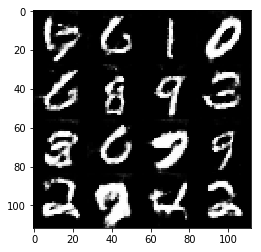

Epoch 1/2, batch 1710... Discriminator Loss: 1.3039... Generator Loss: 0.6469
Epoch 1/2, batch 1720... Discriminator Loss: 1.6564... Generator Loss: 0.8026
Epoch 1/2, batch 1730... Discriminator Loss: 1.5238... Generator Loss: 0.5391
Epoch 1/2, batch 1740... Discriminator Loss: 1.3227... Generator Loss: 0.7076
Epoch 1/2, batch 1750... Discriminator Loss: 1.4274... Generator Loss: 0.5602
Epoch 1/2, batch 1760... Discriminator Loss: 1.4881... Generator Loss: 0.4721
Epoch 1/2, batch 1770... Discriminator Loss: 1.3828... Generator Loss: 0.5762
Epoch 1/2, batch 1780... Discriminator Loss: 1.3588... Generator Loss: 0.5764
Epoch 1/2, batch 1790... Discriminator Loss: 1.5496... Generator Loss: 0.4300
Epoch 1/2, batch 1800... Discriminator Loss: 1.3486... Generator Loss: 0.7871


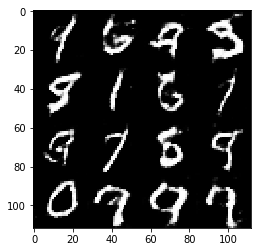

Epoch 1/2, batch 1810... Discriminator Loss: 1.4287... Generator Loss: 0.6453
Epoch 1/2, batch 1820... Discriminator Loss: 1.7547... Generator Loss: 1.2282
Epoch 1/2, batch 1830... Discriminator Loss: 1.3810... Generator Loss: 0.5566
Epoch 1/2, batch 1840... Discriminator Loss: 1.3172... Generator Loss: 0.7532
Epoch 1/2, batch 1850... Discriminator Loss: 1.3065... Generator Loss: 0.8771
Epoch 1/2, batch 1860... Discriminator Loss: 1.5798... Generator Loss: 1.5936
Epoch 1/2, batch 1870... Discriminator Loss: 1.4053... Generator Loss: 0.6264
Epoch 2/2, batch 0... Discriminator Loss: 1.3035... Generator Loss: 0.5400


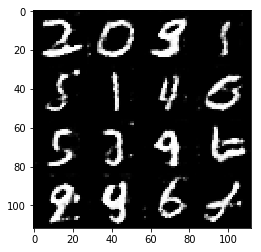

Epoch 2/2, batch 10... Discriminator Loss: 1.8422... Generator Loss: 0.2981
Epoch 2/2, batch 20... Discriminator Loss: 1.5080... Generator Loss: 1.1341
Epoch 2/2, batch 30... Discriminator Loss: 1.6033... Generator Loss: 0.4455
Epoch 2/2, batch 40... Discriminator Loss: 1.4629... Generator Loss: 0.4848
Epoch 2/2, batch 50... Discriminator Loss: 1.7748... Generator Loss: 0.3484
Epoch 2/2, batch 60... Discriminator Loss: 1.3389... Generator Loss: 0.6950
Epoch 2/2, batch 70... Discriminator Loss: 1.7231... Generator Loss: 0.3823
Epoch 2/2, batch 80... Discriminator Loss: 1.5658... Generator Loss: 0.4286
Epoch 2/2, batch 90... Discriminator Loss: 1.4769... Generator Loss: 0.4485
Epoch 2/2, batch 100... Discriminator Loss: 1.3883... Generator Loss: 0.6243


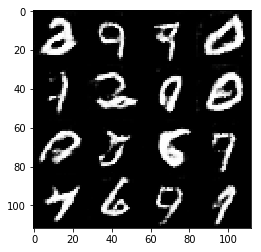

Epoch 2/2, batch 110... Discriminator Loss: 1.2966... Generator Loss: 0.7086
Epoch 2/2, batch 120... Discriminator Loss: 1.3528... Generator Loss: 0.5862
Epoch 2/2, batch 130... Discriminator Loss: 1.3542... Generator Loss: 0.6387
Epoch 2/2, batch 140... Discriminator Loss: 1.3923... Generator Loss: 0.5179
Epoch 2/2, batch 150... Discriminator Loss: 1.5669... Generator Loss: 0.4467
Epoch 2/2, batch 160... Discriminator Loss: 1.3270... Generator Loss: 0.5746
Epoch 2/2, batch 170... Discriminator Loss: 1.2480... Generator Loss: 0.9157
Epoch 2/2, batch 180... Discriminator Loss: 1.4917... Generator Loss: 0.4423
Epoch 2/2, batch 190... Discriminator Loss: 1.2087... Generator Loss: 0.8793
Epoch 2/2, batch 200... Discriminator Loss: 1.2999... Generator Loss: 0.6868


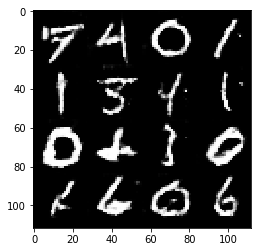

Epoch 2/2, batch 210... Discriminator Loss: 1.4468... Generator Loss: 0.6364
Epoch 2/2, batch 220... Discriminator Loss: 1.2878... Generator Loss: 0.9171
Epoch 2/2, batch 230... Discriminator Loss: 1.3354... Generator Loss: 0.8490
Epoch 2/2, batch 240... Discriminator Loss: 1.8747... Generator Loss: 0.2871
Epoch 2/2, batch 250... Discriminator Loss: 1.3464... Generator Loss: 1.0458
Epoch 2/2, batch 260... Discriminator Loss: 1.2700... Generator Loss: 0.6216
Epoch 2/2, batch 270... Discriminator Loss: 1.3425... Generator Loss: 1.0076
Epoch 2/2, batch 280... Discriminator Loss: 1.3806... Generator Loss: 0.4658
Epoch 2/2, batch 290... Discriminator Loss: 1.6801... Generator Loss: 0.3524
Epoch 2/2, batch 300... Discriminator Loss: 1.4022... Generator Loss: 0.8440


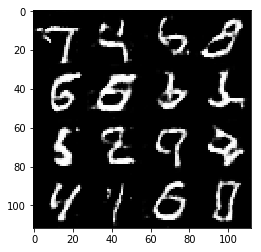

Epoch 2/2, batch 310... Discriminator Loss: 1.2000... Generator Loss: 1.2981
Epoch 2/2, batch 320... Discriminator Loss: 1.3410... Generator Loss: 0.5362
Epoch 2/2, batch 330... Discriminator Loss: 1.1043... Generator Loss: 1.0159
Epoch 2/2, batch 340... Discriminator Loss: 1.2954... Generator Loss: 0.8464
Epoch 2/2, batch 350... Discriminator Loss: 1.5032... Generator Loss: 0.5885
Epoch 2/2, batch 360... Discriminator Loss: 1.4177... Generator Loss: 0.4264
Epoch 2/2, batch 370... Discriminator Loss: 1.4090... Generator Loss: 0.6209
Epoch 2/2, batch 380... Discriminator Loss: 1.3509... Generator Loss: 0.7017
Epoch 2/2, batch 390... Discriminator Loss: 1.3557... Generator Loss: 1.0615
Epoch 2/2, batch 400... Discriminator Loss: 1.3354... Generator Loss: 1.0328


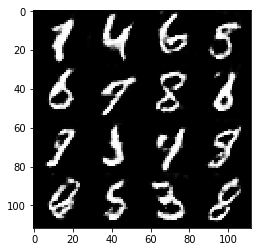

Epoch 2/2, batch 410... Discriminator Loss: 1.2251... Generator Loss: 1.0112
Epoch 2/2, batch 420... Discriminator Loss: 1.0313... Generator Loss: 0.8765
Epoch 2/2, batch 430... Discriminator Loss: 1.4128... Generator Loss: 0.6287
Epoch 2/2, batch 440... Discriminator Loss: 1.4473... Generator Loss: 0.5135
Epoch 2/2, batch 450... Discriminator Loss: 1.1337... Generator Loss: 0.9134
Epoch 2/2, batch 460... Discriminator Loss: 1.1500... Generator Loss: 0.9705
Epoch 2/2, batch 470... Discriminator Loss: 1.5420... Generator Loss: 0.5042
Epoch 2/2, batch 480... Discriminator Loss: 1.2928... Generator Loss: 0.8219
Epoch 2/2, batch 490... Discriminator Loss: 1.2908... Generator Loss: 1.1943
Epoch 2/2, batch 500... Discriminator Loss: 1.1941... Generator Loss: 0.7171


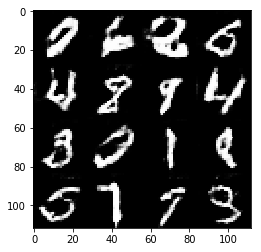

Epoch 2/2, batch 510... Discriminator Loss: 1.6375... Generator Loss: 0.3395
Epoch 2/2, batch 520... Discriminator Loss: 1.3308... Generator Loss: 0.6997
Epoch 2/2, batch 530... Discriminator Loss: 1.5577... Generator Loss: 0.5084
Epoch 2/2, batch 540... Discriminator Loss: 1.3626... Generator Loss: 0.6774
Epoch 2/2, batch 550... Discriminator Loss: 1.2463... Generator Loss: 0.7727
Epoch 2/2, batch 560... Discriminator Loss: 1.7039... Generator Loss: 0.3990
Epoch 2/2, batch 570... Discriminator Loss: 1.3959... Generator Loss: 0.9978
Epoch 2/2, batch 580... Discriminator Loss: 1.2464... Generator Loss: 0.7417
Epoch 2/2, batch 590... Discriminator Loss: 1.3599... Generator Loss: 0.6533
Epoch 2/2, batch 600... Discriminator Loss: 1.1856... Generator Loss: 0.9632


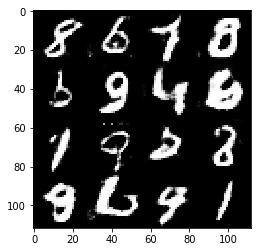

Epoch 2/2, batch 610... Discriminator Loss: 1.7561... Generator Loss: 0.3359
Epoch 2/2, batch 620... Discriminator Loss: 1.3392... Generator Loss: 0.5894
Epoch 2/2, batch 630... Discriminator Loss: 1.2740... Generator Loss: 0.8575
Epoch 2/2, batch 640... Discriminator Loss: 1.2548... Generator Loss: 1.4474
Epoch 2/2, batch 650... Discriminator Loss: 1.3703... Generator Loss: 1.4814
Epoch 2/2, batch 660... Discriminator Loss: 1.4478... Generator Loss: 0.4796
Epoch 2/2, batch 670... Discriminator Loss: 1.2580... Generator Loss: 0.6625
Epoch 2/2, batch 680... Discriminator Loss: 1.8180... Generator Loss: 0.3827
Epoch 2/2, batch 690... Discriminator Loss: 1.7676... Generator Loss: 0.3799
Epoch 2/2, batch 700... Discriminator Loss: 2.0384... Generator Loss: 0.2434


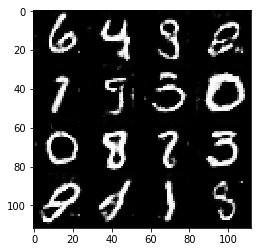

Epoch 2/2, batch 710... Discriminator Loss: 1.5007... Generator Loss: 0.5503
Epoch 2/2, batch 720... Discriminator Loss: 1.5083... Generator Loss: 0.4596
Epoch 2/2, batch 730... Discriminator Loss: 1.3870... Generator Loss: 0.6011
Epoch 2/2, batch 740... Discriminator Loss: 1.1728... Generator Loss: 0.7589
Epoch 2/2, batch 750... Discriminator Loss: 1.3050... Generator Loss: 0.5150
Epoch 2/2, batch 760... Discriminator Loss: 1.0665... Generator Loss: 0.8982
Epoch 2/2, batch 770... Discriminator Loss: 1.6154... Generator Loss: 2.1147
Epoch 2/2, batch 780... Discriminator Loss: 1.2313... Generator Loss: 1.2731
Epoch 2/2, batch 790... Discriminator Loss: 1.1522... Generator Loss: 0.7904
Epoch 2/2, batch 800... Discriminator Loss: 1.6112... Generator Loss: 1.1021


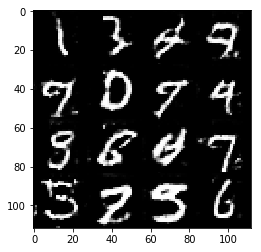

Epoch 2/2, batch 810... Discriminator Loss: 1.3628... Generator Loss: 0.8589
Epoch 2/2, batch 820... Discriminator Loss: 1.4595... Generator Loss: 0.5864
Epoch 2/2, batch 830... Discriminator Loss: 1.3361... Generator Loss: 0.6721
Epoch 2/2, batch 840... Discriminator Loss: 1.4738... Generator Loss: 1.3304
Epoch 2/2, batch 850... Discriminator Loss: 1.2757... Generator Loss: 0.7729
Epoch 2/2, batch 860... Discriminator Loss: 1.4405... Generator Loss: 0.5260
Epoch 2/2, batch 870... Discriminator Loss: 1.1370... Generator Loss: 0.9834
Epoch 2/2, batch 880... Discriminator Loss: 1.3910... Generator Loss: 0.5679
Epoch 2/2, batch 890... Discriminator Loss: 2.1437... Generator Loss: 0.2045
Epoch 2/2, batch 900... Discriminator Loss: 1.3578... Generator Loss: 0.5888


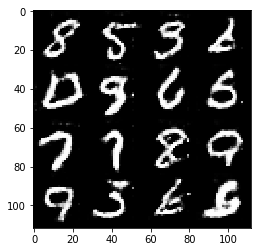

Epoch 2/2, batch 910... Discriminator Loss: 1.4352... Generator Loss: 0.6027
Epoch 2/2, batch 920... Discriminator Loss: 1.5220... Generator Loss: 0.4494
Epoch 2/2, batch 930... Discriminator Loss: 1.3739... Generator Loss: 0.4235
Epoch 2/2, batch 940... Discriminator Loss: 1.5481... Generator Loss: 0.3908
Epoch 2/2, batch 950... Discriminator Loss: 1.2380... Generator Loss: 0.6981
Epoch 2/2, batch 960... Discriminator Loss: 1.4481... Generator Loss: 0.7254
Epoch 2/2, batch 970... Discriminator Loss: 1.3897... Generator Loss: 0.6231
Epoch 2/2, batch 980... Discriminator Loss: 1.2334... Generator Loss: 1.3992
Epoch 2/2, batch 990... Discriminator Loss: 1.1805... Generator Loss: 0.8561
Epoch 2/2, batch 1000... Discriminator Loss: 1.1871... Generator Loss: 1.2025


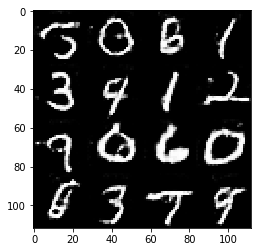

Epoch 2/2, batch 1010... Discriminator Loss: 1.1736... Generator Loss: 0.9930
Epoch 2/2, batch 1020... Discriminator Loss: 1.3844... Generator Loss: 0.5691
Epoch 2/2, batch 1030... Discriminator Loss: 1.2920... Generator Loss: 0.7985
Epoch 2/2, batch 1040... Discriminator Loss: 1.5103... Generator Loss: 0.5281
Epoch 2/2, batch 1050... Discriminator Loss: 1.3279... Generator Loss: 0.7652
Epoch 2/2, batch 1060... Discriminator Loss: 1.2615... Generator Loss: 0.5291
Epoch 2/2, batch 1070... Discriminator Loss: 1.5778... Generator Loss: 1.1576
Epoch 2/2, batch 1080... Discriminator Loss: 1.3722... Generator Loss: 0.7114
Epoch 2/2, batch 1090... Discriminator Loss: 1.5661... Generator Loss: 1.5243
Epoch 2/2, batch 1100... Discriminator Loss: 1.3254... Generator Loss: 1.5192


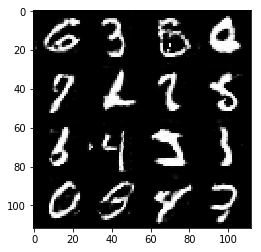

Epoch 2/2, batch 1110... Discriminator Loss: 1.3449... Generator Loss: 0.6142
Epoch 2/2, batch 1120... Discriminator Loss: 1.0546... Generator Loss: 1.0394
Epoch 2/2, batch 1130... Discriminator Loss: 1.1812... Generator Loss: 0.6206
Epoch 2/2, batch 1140... Discriminator Loss: 1.5388... Generator Loss: 1.5817
Epoch 2/2, batch 1150... Discriminator Loss: 1.1431... Generator Loss: 0.7004
Epoch 2/2, batch 1160... Discriminator Loss: 1.4103... Generator Loss: 1.3448
Epoch 2/2, batch 1170... Discriminator Loss: 1.5020... Generator Loss: 0.5210
Epoch 2/2, batch 1180... Discriminator Loss: 1.3964... Generator Loss: 0.5705
Epoch 2/2, batch 1190... Discriminator Loss: 1.9221... Generator Loss: 0.3279
Epoch 2/2, batch 1200... Discriminator Loss: 1.4082... Generator Loss: 0.5194


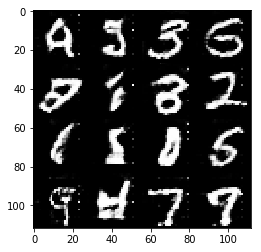

Epoch 2/2, batch 1210... Discriminator Loss: 1.3059... Generator Loss: 0.6539
Epoch 2/2, batch 1220... Discriminator Loss: 1.2265... Generator Loss: 0.6034
Epoch 2/2, batch 1230... Discriminator Loss: 1.0839... Generator Loss: 0.9826
Epoch 2/2, batch 1240... Discriminator Loss: 1.1685... Generator Loss: 1.4800
Epoch 2/2, batch 1250... Discriminator Loss: 1.4279... Generator Loss: 0.8043
Epoch 2/2, batch 1260... Discriminator Loss: 1.6192... Generator Loss: 0.4680
Epoch 2/2, batch 1270... Discriminator Loss: 1.4035... Generator Loss: 0.7771
Epoch 2/2, batch 1280... Discriminator Loss: 1.2187... Generator Loss: 0.9614
Epoch 2/2, batch 1290... Discriminator Loss: 1.1243... Generator Loss: 1.3201
Epoch 2/2, batch 1300... Discriminator Loss: 1.4547... Generator Loss: 0.7519


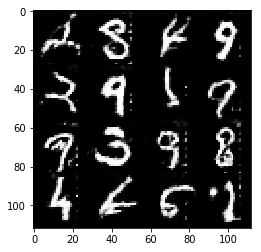

Epoch 2/2, batch 1310... Discriminator Loss: 1.1116... Generator Loss: 0.7970
Epoch 2/2, batch 1320... Discriminator Loss: 1.4203... Generator Loss: 0.6346
Epoch 2/2, batch 1330... Discriminator Loss: 1.9399... Generator Loss: 0.2907
Epoch 2/2, batch 1340... Discriminator Loss: 1.3635... Generator Loss: 1.7665
Epoch 2/2, batch 1350... Discriminator Loss: 1.3577... Generator Loss: 0.7499
Epoch 2/2, batch 1360... Discriminator Loss: 1.1101... Generator Loss: 0.9091
Epoch 2/2, batch 1370... Discriminator Loss: 1.2634... Generator Loss: 0.7781
Epoch 2/2, batch 1380... Discriminator Loss: 1.4302... Generator Loss: 0.4822
Epoch 2/2, batch 1390... Discriminator Loss: 1.5824... Generator Loss: 0.5928
Epoch 2/2, batch 1400... Discriminator Loss: 1.2448... Generator Loss: 0.7436


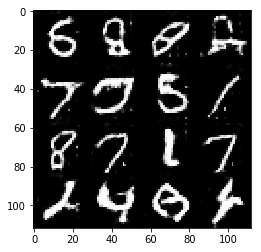

Epoch 2/2, batch 1410... Discriminator Loss: 1.1204... Generator Loss: 0.6895
Epoch 2/2, batch 1420... Discriminator Loss: 1.2635... Generator Loss: 0.6701
Epoch 2/2, batch 1430... Discriminator Loss: 1.3290... Generator Loss: 1.1558
Epoch 2/2, batch 1440... Discriminator Loss: 1.4962... Generator Loss: 0.4280
Epoch 2/2, batch 1450... Discriminator Loss: 1.2574... Generator Loss: 1.4478
Epoch 2/2, batch 1460... Discriminator Loss: 1.7321... Generator Loss: 0.2650
Epoch 2/2, batch 1470... Discriminator Loss: 1.5847... Generator Loss: 1.8585
Epoch 2/2, batch 1480... Discriminator Loss: 1.2989... Generator Loss: 0.8490
Epoch 2/2, batch 1490... Discriminator Loss: 1.6602... Generator Loss: 0.5141
Epoch 2/2, batch 1500... Discriminator Loss: 1.2389... Generator Loss: 0.5779


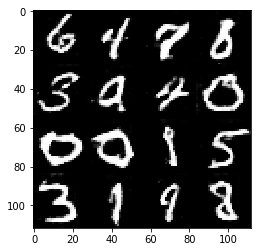

Epoch 2/2, batch 1510... Discriminator Loss: 1.9526... Generator Loss: 0.2816
Epoch 2/2, batch 1520... Discriminator Loss: 1.4714... Generator Loss: 1.2398
Epoch 2/2, batch 1530... Discriminator Loss: 1.2357... Generator Loss: 0.7272
Epoch 2/2, batch 1540... Discriminator Loss: 0.9570... Generator Loss: 1.4657
Epoch 2/2, batch 1550... Discriminator Loss: 1.4582... Generator Loss: 0.7010
Epoch 2/2, batch 1560... Discriminator Loss: 1.2013... Generator Loss: 0.5294
Epoch 2/2, batch 1570... Discriminator Loss: 1.5511... Generator Loss: 0.3656
Epoch 2/2, batch 1580... Discriminator Loss: 1.4446... Generator Loss: 0.4051
Epoch 2/2, batch 1590... Discriminator Loss: 1.4868... Generator Loss: 0.5798
Epoch 2/2, batch 1600... Discriminator Loss: 1.6823... Generator Loss: 0.4932


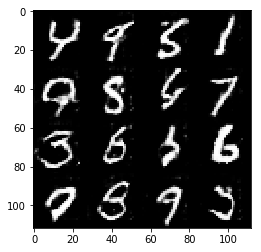

Epoch 2/2, batch 1610... Discriminator Loss: 1.2515... Generator Loss: 1.3289
Epoch 2/2, batch 1620... Discriminator Loss: 1.0834... Generator Loss: 1.1518
Epoch 2/2, batch 1630... Discriminator Loss: 1.1435... Generator Loss: 1.1198
Epoch 2/2, batch 1640... Discriminator Loss: 1.5178... Generator Loss: 0.4977
Epoch 2/2, batch 1650... Discriminator Loss: 0.9386... Generator Loss: 1.4341
Epoch 2/2, batch 1660... Discriminator Loss: 1.2328... Generator Loss: 0.8207
Epoch 2/2, batch 1670... Discriminator Loss: 1.6204... Generator Loss: 1.9191
Epoch 2/2, batch 1680... Discriminator Loss: 1.3529... Generator Loss: 0.4774
Epoch 2/2, batch 1690... Discriminator Loss: 1.3457... Generator Loss: 0.6820
Epoch 2/2, batch 1700... Discriminator Loss: 1.2982... Generator Loss: 0.7408


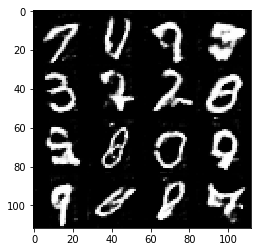

Epoch 2/2, batch 1710... Discriminator Loss: 1.2154... Generator Loss: 0.6332
Epoch 2/2, batch 1720... Discriminator Loss: 1.1562... Generator Loss: 1.2406
Epoch 2/2, batch 1730... Discriminator Loss: 1.1267... Generator Loss: 0.9561
Epoch 2/2, batch 1740... Discriminator Loss: 1.6646... Generator Loss: 0.4098
Epoch 2/2, batch 1750... Discriminator Loss: 1.7091... Generator Loss: 1.8032
Epoch 2/2, batch 1760... Discriminator Loss: 1.2120... Generator Loss: 0.9764
Epoch 2/2, batch 1770... Discriminator Loss: 1.2810... Generator Loss: 0.7660
Epoch 2/2, batch 1780... Discriminator Loss: 1.8105... Generator Loss: 0.4067
Epoch 2/2, batch 1790... Discriminator Loss: 1.3415... Generator Loss: 0.4816
Epoch 2/2, batch 1800... Discriminator Loss: 1.3612... Generator Loss: 0.6305


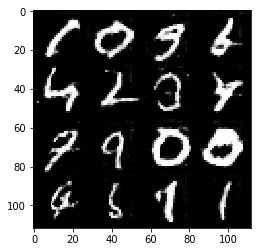

Epoch 2/2, batch 1810... Discriminator Loss: 1.2910... Generator Loss: 0.3960
Epoch 2/2, batch 1820... Discriminator Loss: 1.1133... Generator Loss: 1.0025
Epoch 2/2, batch 1830... Discriminator Loss: 1.2968... Generator Loss: 0.5699
Epoch 2/2, batch 1840... Discriminator Loss: 1.3484... Generator Loss: 1.1779
Epoch 2/2, batch 1850... Discriminator Loss: 1.3184... Generator Loss: 0.6560
Epoch 2/2, batch 1860... Discriminator Loss: 1.3008... Generator Loss: 0.9792
Epoch 2/2, batch 1870... Discriminator Loss: 1.4470... Generator Loss: 1.5309


In [98]:
batch_size = 32
z_dim = 200
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, batch 0... Discriminator Loss: 7.5461... Generator Loss: 0.0011


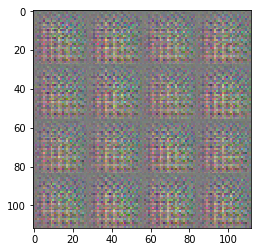

Epoch 1/1, batch 10... Discriminator Loss: 4.7342... Generator Loss: 0.1262
Epoch 1/1, batch 20... Discriminator Loss: 1.9305... Generator Loss: 2.4878
Epoch 1/1, batch 30... Discriminator Loss: 3.1071... Generator Loss: 0.2485
Epoch 1/1, batch 40... Discriminator Loss: 2.3938... Generator Loss: 0.2577
Epoch 1/1, batch 50... Discriminator Loss: 1.5882... Generator Loss: 0.8764
Epoch 1/1, batch 60... Discriminator Loss: 1.0469... Generator Loss: 1.3668
Epoch 1/1, batch 70... Discriminator Loss: 1.4818... Generator Loss: 0.6690
Epoch 1/1, batch 80... Discriminator Loss: 1.7271... Generator Loss: 0.4186
Epoch 1/1, batch 90... Discriminator Loss: 2.4079... Generator Loss: 0.3199
Epoch 1/1, batch 100... Discriminator Loss: 1.7644... Generator Loss: 0.7007


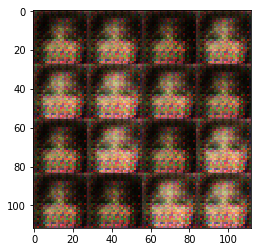

Epoch 1/1, batch 110... Discriminator Loss: 1.8221... Generator Loss: 0.6272
Epoch 1/1, batch 120... Discriminator Loss: 1.5443... Generator Loss: 0.7713
Epoch 1/1, batch 130... Discriminator Loss: 1.5523... Generator Loss: 0.8534
Epoch 1/1, batch 140... Discriminator Loss: 1.7848... Generator Loss: 0.6403
Epoch 1/1, batch 150... Discriminator Loss: 1.5166... Generator Loss: 0.5791
Epoch 1/1, batch 160... Discriminator Loss: 1.9387... Generator Loss: 0.5088
Epoch 1/1, batch 170... Discriminator Loss: 1.3055... Generator Loss: 1.0492
Epoch 1/1, batch 180... Discriminator Loss: 1.4986... Generator Loss: 0.5659
Epoch 1/1, batch 190... Discriminator Loss: 1.4770... Generator Loss: 0.8433
Epoch 1/1, batch 200... Discriminator Loss: 2.0370... Generator Loss: 0.5153


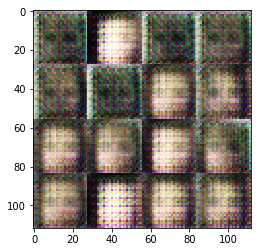

Epoch 1/1, batch 210... Discriminator Loss: 1.6607... Generator Loss: 0.5829
Epoch 1/1, batch 220... Discriminator Loss: 1.4105... Generator Loss: 0.7938
Epoch 1/1, batch 230... Discriminator Loss: 1.3282... Generator Loss: 0.9050
Epoch 1/1, batch 240... Discriminator Loss: 1.4548... Generator Loss: 0.7110
Epoch 1/1, batch 250... Discriminator Loss: 1.3452... Generator Loss: 0.8339
Epoch 1/1, batch 260... Discriminator Loss: 1.5494... Generator Loss: 0.7284
Epoch 1/1, batch 270... Discriminator Loss: 1.6153... Generator Loss: 0.7640
Epoch 1/1, batch 280... Discriminator Loss: 1.4349... Generator Loss: 0.6981
Epoch 1/1, batch 290... Discriminator Loss: 1.7631... Generator Loss: 0.4976
Epoch 1/1, batch 300... Discriminator Loss: 1.5339... Generator Loss: 0.7087


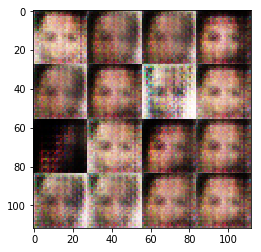

Epoch 1/1, batch 310... Discriminator Loss: 1.5951... Generator Loss: 0.6109
Epoch 1/1, batch 320... Discriminator Loss: 1.5311... Generator Loss: 0.7123
Epoch 1/1, batch 330... Discriminator Loss: 1.3801... Generator Loss: 0.8168
Epoch 1/1, batch 340... Discriminator Loss: 1.6412... Generator Loss: 0.7335
Epoch 1/1, batch 350... Discriminator Loss: 1.4615... Generator Loss: 0.7816
Epoch 1/1, batch 360... Discriminator Loss: 1.3224... Generator Loss: 0.9772
Epoch 1/1, batch 370... Discriminator Loss: 1.4999... Generator Loss: 0.8221
Epoch 1/1, batch 380... Discriminator Loss: 1.5475... Generator Loss: 0.6451
Epoch 1/1, batch 390... Discriminator Loss: 1.4298... Generator Loss: 0.7692
Epoch 1/1, batch 400... Discriminator Loss: 1.3472... Generator Loss: 0.7735


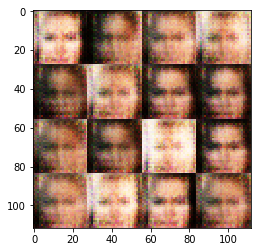

Epoch 1/1, batch 410... Discriminator Loss: 1.6325... Generator Loss: 0.5945
Epoch 1/1, batch 420... Discriminator Loss: 1.7375... Generator Loss: 0.6974
Epoch 1/1, batch 430... Discriminator Loss: 1.4720... Generator Loss: 0.7998
Epoch 1/1, batch 440... Discriminator Loss: 1.6472... Generator Loss: 0.6897
Epoch 1/1, batch 450... Discriminator Loss: 1.5445... Generator Loss: 0.6798
Epoch 1/1, batch 460... Discriminator Loss: 1.4365... Generator Loss: 0.8335
Epoch 1/1, batch 470... Discriminator Loss: 1.6871... Generator Loss: 0.6240
Epoch 1/1, batch 480... Discriminator Loss: 1.6748... Generator Loss: 0.6679
Epoch 1/1, batch 490... Discriminator Loss: 1.4798... Generator Loss: 0.7673
Epoch 1/1, batch 500... Discriminator Loss: 1.4484... Generator Loss: 0.8290


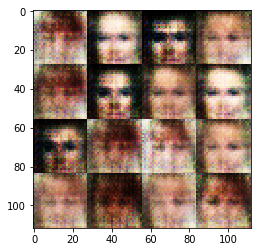

Epoch 1/1, batch 510... Discriminator Loss: 1.5660... Generator Loss: 0.6318
Epoch 1/1, batch 520... Discriminator Loss: 1.5613... Generator Loss: 0.5458
Epoch 1/1, batch 530... Discriminator Loss: 1.6495... Generator Loss: 0.7046
Epoch 1/1, batch 540... Discriminator Loss: 1.5441... Generator Loss: 0.7379
Epoch 1/1, batch 550... Discriminator Loss: 1.6025... Generator Loss: 0.6971
Epoch 1/1, batch 560... Discriminator Loss: 1.5643... Generator Loss: 0.7108
Epoch 1/1, batch 570... Discriminator Loss: 1.5726... Generator Loss: 0.7529
Epoch 1/1, batch 580... Discriminator Loss: 1.5481... Generator Loss: 0.7135
Epoch 1/1, batch 590... Discriminator Loss: 1.5043... Generator Loss: 0.6505
Epoch 1/1, batch 600... Discriminator Loss: 1.5847... Generator Loss: 0.6887


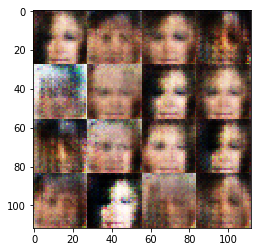

Epoch 1/1, batch 610... Discriminator Loss: 1.4655... Generator Loss: 0.7277
Epoch 1/1, batch 620... Discriminator Loss: 1.4159... Generator Loss: 0.8114
Epoch 1/1, batch 630... Discriminator Loss: 1.4825... Generator Loss: 0.5878
Epoch 1/1, batch 640... Discriminator Loss: 1.5906... Generator Loss: 0.6577
Epoch 1/1, batch 650... Discriminator Loss: 1.4513... Generator Loss: 0.7585
Epoch 1/1, batch 660... Discriminator Loss: 1.5661... Generator Loss: 0.6274
Epoch 1/1, batch 670... Discriminator Loss: 1.4690... Generator Loss: 0.7758
Epoch 1/1, batch 680... Discriminator Loss: 1.4755... Generator Loss: 0.9447
Epoch 1/1, batch 690... Discriminator Loss: 1.4897... Generator Loss: 0.7424
Epoch 1/1, batch 700... Discriminator Loss: 1.4355... Generator Loss: 0.7466


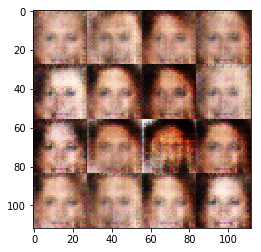

Epoch 1/1, batch 710... Discriminator Loss: 1.4600... Generator Loss: 0.7705
Epoch 1/1, batch 720... Discriminator Loss: 1.4812... Generator Loss: 0.7093
Epoch 1/1, batch 730... Discriminator Loss: 1.5391... Generator Loss: 0.6714
Epoch 1/1, batch 740... Discriminator Loss: 1.3694... Generator Loss: 0.7862
Epoch 1/1, batch 750... Discriminator Loss: 1.4896... Generator Loss: 0.7259
Epoch 1/1, batch 760... Discriminator Loss: 1.5154... Generator Loss: 0.7610
Epoch 1/1, batch 770... Discriminator Loss: 1.4962... Generator Loss: 0.6512
Epoch 1/1, batch 780... Discriminator Loss: 1.4718... Generator Loss: 0.6978
Epoch 1/1, batch 790... Discriminator Loss: 1.4720... Generator Loss: 0.6091
Epoch 1/1, batch 800... Discriminator Loss: 1.6353... Generator Loss: 0.5868


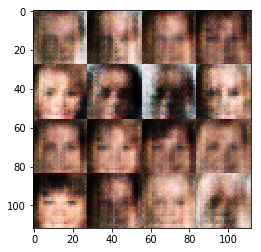

Epoch 1/1, batch 810... Discriminator Loss: 1.4953... Generator Loss: 0.7196
Epoch 1/1, batch 820... Discriminator Loss: 1.5267... Generator Loss: 0.7031
Epoch 1/1, batch 830... Discriminator Loss: 1.4535... Generator Loss: 0.7725
Epoch 1/1, batch 840... Discriminator Loss: 1.4993... Generator Loss: 0.6989
Epoch 1/1, batch 850... Discriminator Loss: 1.5657... Generator Loss: 0.6563
Epoch 1/1, batch 860... Discriminator Loss: 1.4847... Generator Loss: 0.7711
Epoch 1/1, batch 870... Discriminator Loss: 1.4343... Generator Loss: 0.7360
Epoch 1/1, batch 880... Discriminator Loss: 1.4175... Generator Loss: 0.7726
Epoch 1/1, batch 890... Discriminator Loss: 1.4966... Generator Loss: 0.7668
Epoch 1/1, batch 900... Discriminator Loss: 1.4917... Generator Loss: 0.7276


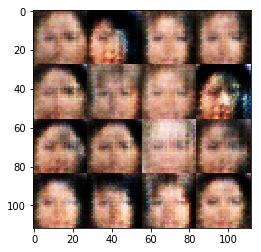

Epoch 1/1, batch 910... Discriminator Loss: 1.5042... Generator Loss: 0.6897
Epoch 1/1, batch 920... Discriminator Loss: 1.4922... Generator Loss: 0.6997
Epoch 1/1, batch 930... Discriminator Loss: 1.4616... Generator Loss: 0.7252
Epoch 1/1, batch 940... Discriminator Loss: 1.4983... Generator Loss: 0.7238
Epoch 1/1, batch 950... Discriminator Loss: 1.4384... Generator Loss: 0.7143
Epoch 1/1, batch 960... Discriminator Loss: 1.4426... Generator Loss: 0.6411
Epoch 1/1, batch 970... Discriminator Loss: 1.4589... Generator Loss: 0.7415
Epoch 1/1, batch 980... Discriminator Loss: 1.5606... Generator Loss: 0.7523
Epoch 1/1, batch 990... Discriminator Loss: 1.4697... Generator Loss: 0.8488
Epoch 1/1, batch 1000... Discriminator Loss: 1.4765... Generator Loss: 0.7097


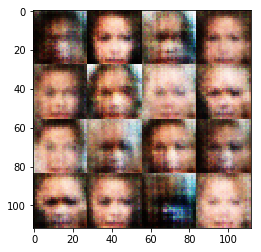

Epoch 1/1, batch 1010... Discriminator Loss: 1.4950... Generator Loss: 0.7642
Epoch 1/1, batch 1020... Discriminator Loss: 1.4069... Generator Loss: 0.7732
Epoch 1/1, batch 1030... Discriminator Loss: 1.3722... Generator Loss: 0.7601
Epoch 1/1, batch 1040... Discriminator Loss: 1.4235... Generator Loss: 0.6668
Epoch 1/1, batch 1050... Discriminator Loss: 1.4998... Generator Loss: 0.6723
Epoch 1/1, batch 1060... Discriminator Loss: 1.4621... Generator Loss: 0.8366
Epoch 1/1, batch 1070... Discriminator Loss: 1.4057... Generator Loss: 0.7893
Epoch 1/1, batch 1080... Discriminator Loss: 1.3664... Generator Loss: 0.7778
Epoch 1/1, batch 1090... Discriminator Loss: 1.4797... Generator Loss: 0.7628
Epoch 1/1, batch 1100... Discriminator Loss: 1.4531... Generator Loss: 0.7340


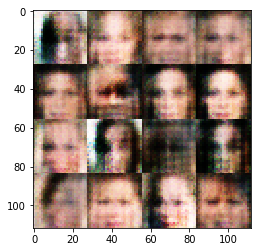

Epoch 1/1, batch 1110... Discriminator Loss: 1.5290... Generator Loss: 0.6915
Epoch 1/1, batch 1120... Discriminator Loss: 1.3746... Generator Loss: 0.8375
Epoch 1/1, batch 1130... Discriminator Loss: 1.4300... Generator Loss: 0.7910
Epoch 1/1, batch 1140... Discriminator Loss: 1.3912... Generator Loss: 0.8697
Epoch 1/1, batch 1150... Discriminator Loss: 1.4697... Generator Loss: 0.6260
Epoch 1/1, batch 1160... Discriminator Loss: 1.4138... Generator Loss: 0.7826
Epoch 1/1, batch 1170... Discriminator Loss: 1.4416... Generator Loss: 0.7666
Epoch 1/1, batch 1180... Discriminator Loss: 1.4939... Generator Loss: 0.7695
Epoch 1/1, batch 1190... Discriminator Loss: 1.4383... Generator Loss: 0.7955
Epoch 1/1, batch 1200... Discriminator Loss: 1.5560... Generator Loss: 0.7137


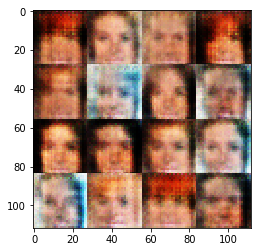

Epoch 1/1, batch 1210... Discriminator Loss: 1.4480... Generator Loss: 0.8931
Epoch 1/1, batch 1220... Discriminator Loss: 1.4656... Generator Loss: 0.7605
Epoch 1/1, batch 1230... Discriminator Loss: 1.4893... Generator Loss: 0.7474
Epoch 1/1, batch 1240... Discriminator Loss: 1.4035... Generator Loss: 0.7935
Epoch 1/1, batch 1250... Discriminator Loss: 1.4179... Generator Loss: 0.8463
Epoch 1/1, batch 1260... Discriminator Loss: 1.4456... Generator Loss: 0.7180
Epoch 1/1, batch 1270... Discriminator Loss: 1.3842... Generator Loss: 0.7334
Epoch 1/1, batch 1280... Discriminator Loss: 1.4613... Generator Loss: 0.8440
Epoch 1/1, batch 1290... Discriminator Loss: 1.4183... Generator Loss: 0.7329
Epoch 1/1, batch 1300... Discriminator Loss: 1.4659... Generator Loss: 0.7697


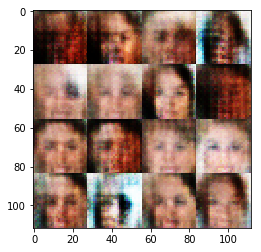

Epoch 1/1, batch 1310... Discriminator Loss: 1.5204... Generator Loss: 0.7109
Epoch 1/1, batch 1320... Discriminator Loss: 1.3685... Generator Loss: 0.7419
Epoch 1/1, batch 1330... Discriminator Loss: 1.4130... Generator Loss: 0.7718
Epoch 1/1, batch 1340... Discriminator Loss: 1.4612... Generator Loss: 0.7541
Epoch 1/1, batch 1350... Discriminator Loss: 1.4374... Generator Loss: 0.7564
Epoch 1/1, batch 1360... Discriminator Loss: 1.4420... Generator Loss: 0.7132
Epoch 1/1, batch 1370... Discriminator Loss: 1.4572... Generator Loss: 0.7702
Epoch 1/1, batch 1380... Discriminator Loss: 1.4055... Generator Loss: 0.7177
Epoch 1/1, batch 1390... Discriminator Loss: 1.3757... Generator Loss: 0.7952
Epoch 1/1, batch 1400... Discriminator Loss: 1.4080... Generator Loss: 0.6971


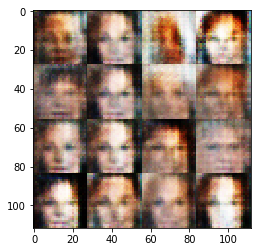

Epoch 1/1, batch 1410... Discriminator Loss: 1.4649... Generator Loss: 0.6823
Epoch 1/1, batch 1420... Discriminator Loss: 1.4909... Generator Loss: 0.7128
Epoch 1/1, batch 1430... Discriminator Loss: 1.4016... Generator Loss: 0.7911
Epoch 1/1, batch 1440... Discriminator Loss: 1.4809... Generator Loss: 0.6894
Epoch 1/1, batch 1450... Discriminator Loss: 1.4287... Generator Loss: 0.7241
Epoch 1/1, batch 1460... Discriminator Loss: 1.4625... Generator Loss: 0.6779
Epoch 1/1, batch 1470... Discriminator Loss: 1.4656... Generator Loss: 0.7559
Epoch 1/1, batch 1480... Discriminator Loss: 1.4792... Generator Loss: 0.6112
Epoch 1/1, batch 1490... Discriminator Loss: 1.4376... Generator Loss: 0.6978
Epoch 1/1, batch 1500... Discriminator Loss: 1.5165... Generator Loss: 0.6598


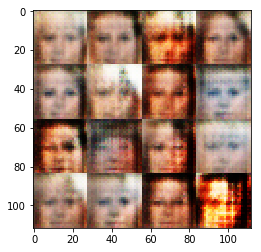

Epoch 1/1, batch 1510... Discriminator Loss: 1.4535... Generator Loss: 0.7119
Epoch 1/1, batch 1520... Discriminator Loss: 1.4163... Generator Loss: 0.7740
Epoch 1/1, batch 1530... Discriminator Loss: 1.4814... Generator Loss: 0.6970
Epoch 1/1, batch 1540... Discriminator Loss: 1.3985... Generator Loss: 0.7149
Epoch 1/1, batch 1550... Discriminator Loss: 1.4267... Generator Loss: 0.7470
Epoch 1/1, batch 1560... Discriminator Loss: 1.4133... Generator Loss: 0.7662
Epoch 1/1, batch 1570... Discriminator Loss: 1.4261... Generator Loss: 0.7350
Epoch 1/1, batch 1580... Discriminator Loss: 1.4600... Generator Loss: 0.6568
Epoch 1/1, batch 1590... Discriminator Loss: 1.4399... Generator Loss: 0.7343
Epoch 1/1, batch 1600... Discriminator Loss: 1.4638... Generator Loss: 0.7962


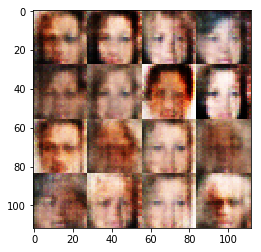

Epoch 1/1, batch 1610... Discriminator Loss: 1.3983... Generator Loss: 0.8551
Epoch 1/1, batch 1620... Discriminator Loss: 1.4330... Generator Loss: 0.6688
Epoch 1/1, batch 1630... Discriminator Loss: 1.3978... Generator Loss: 0.6834
Epoch 1/1, batch 1640... Discriminator Loss: 1.4089... Generator Loss: 0.7387
Epoch 1/1, batch 1650... Discriminator Loss: 1.4267... Generator Loss: 0.7966
Epoch 1/1, batch 1660... Discriminator Loss: 1.4524... Generator Loss: 0.7600
Epoch 1/1, batch 1670... Discriminator Loss: 1.4409... Generator Loss: 0.6842
Epoch 1/1, batch 1680... Discriminator Loss: 1.4227... Generator Loss: 0.7878
Epoch 1/1, batch 1690... Discriminator Loss: 1.3839... Generator Loss: 0.7622
Epoch 1/1, batch 1700... Discriminator Loss: 1.4378... Generator Loss: 0.7537


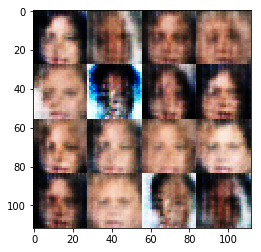

Epoch 1/1, batch 1710... Discriminator Loss: 1.4080... Generator Loss: 0.7124
Epoch 1/1, batch 1720... Discriminator Loss: 1.4832... Generator Loss: 0.6495
Epoch 1/1, batch 1730... Discriminator Loss: 1.4394... Generator Loss: 0.8601
Epoch 1/1, batch 1740... Discriminator Loss: 1.4936... Generator Loss: 0.6953
Epoch 1/1, batch 1750... Discriminator Loss: 1.4379... Generator Loss: 0.7039
Epoch 1/1, batch 1760... Discriminator Loss: 1.3801... Generator Loss: 0.6653
Epoch 1/1, batch 1770... Discriminator Loss: 1.4679... Generator Loss: 0.7235
Epoch 1/1, batch 1780... Discriminator Loss: 1.3864... Generator Loss: 0.8342
Epoch 1/1, batch 1790... Discriminator Loss: 1.4403... Generator Loss: 0.8704
Epoch 1/1, batch 1800... Discriminator Loss: 1.5882... Generator Loss: 0.6152


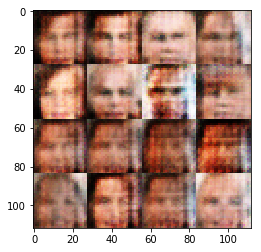

Epoch 1/1, batch 1810... Discriminator Loss: 1.4531... Generator Loss: 0.7187
Epoch 1/1, batch 1820... Discriminator Loss: 1.4431... Generator Loss: 0.7443
Epoch 1/1, batch 1830... Discriminator Loss: 1.3390... Generator Loss: 0.7931
Epoch 1/1, batch 1840... Discriminator Loss: 1.4407... Generator Loss: 0.7380
Epoch 1/1, batch 1850... Discriminator Loss: 1.4644... Generator Loss: 0.7474
Epoch 1/1, batch 1860... Discriminator Loss: 1.3836... Generator Loss: 0.7801
Epoch 1/1, batch 1870... Discriminator Loss: 1.4433... Generator Loss: 0.7252
Epoch 1/1, batch 1880... Discriminator Loss: 1.4587... Generator Loss: 0.7890
Epoch 1/1, batch 1890... Discriminator Loss: 1.4091... Generator Loss: 0.7931
Epoch 1/1, batch 1900... Discriminator Loss: 1.4495... Generator Loss: 0.6857


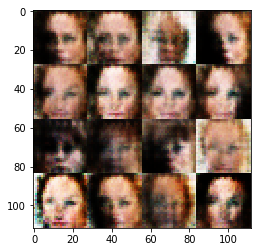

Epoch 1/1, batch 1910... Discriminator Loss: 1.4002... Generator Loss: 0.8441
Epoch 1/1, batch 1920... Discriminator Loss: 1.3861... Generator Loss: 0.7974
Epoch 1/1, batch 1930... Discriminator Loss: 1.4032... Generator Loss: 0.7832
Epoch 1/1, batch 1940... Discriminator Loss: 1.4903... Generator Loss: 0.6408
Epoch 1/1, batch 1950... Discriminator Loss: 1.4677... Generator Loss: 0.7343
Epoch 1/1, batch 1960... Discriminator Loss: 1.4258... Generator Loss: 0.7569
Epoch 1/1, batch 1970... Discriminator Loss: 1.4466... Generator Loss: 0.7619
Epoch 1/1, batch 1980... Discriminator Loss: 1.4306... Generator Loss: 0.7528
Epoch 1/1, batch 1990... Discriminator Loss: 1.4105... Generator Loss: 0.7696
Epoch 1/1, batch 2000... Discriminator Loss: 1.4653... Generator Loss: 0.7168


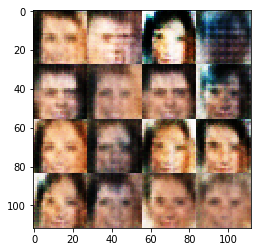

Epoch 1/1, batch 2010... Discriminator Loss: 1.4145... Generator Loss: 0.7797
Epoch 1/1, batch 2020... Discriminator Loss: 1.4272... Generator Loss: 0.6930
Epoch 1/1, batch 2030... Discriminator Loss: 1.4879... Generator Loss: 0.7736
Epoch 1/1, batch 2040... Discriminator Loss: 1.4963... Generator Loss: 0.7181
Epoch 1/1, batch 2050... Discriminator Loss: 1.3882... Generator Loss: 0.7435
Epoch 1/1, batch 2060... Discriminator Loss: 1.4283... Generator Loss: 0.7097
Epoch 1/1, batch 2070... Discriminator Loss: 1.4712... Generator Loss: 0.7632
Epoch 1/1, batch 2080... Discriminator Loss: 1.4025... Generator Loss: 0.7847
Epoch 1/1, batch 2090... Discriminator Loss: 1.4518... Generator Loss: 0.7201
Epoch 1/1, batch 2100... Discriminator Loss: 1.4175... Generator Loss: 0.7170


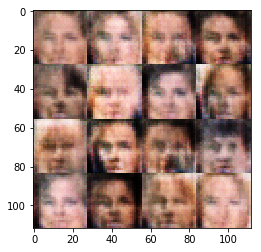

Epoch 1/1, batch 2110... Discriminator Loss: 1.4270... Generator Loss: 0.7573
Epoch 1/1, batch 2120... Discriminator Loss: 1.4390... Generator Loss: 0.7380
Epoch 1/1, batch 2130... Discriminator Loss: 1.4490... Generator Loss: 0.6754
Epoch 1/1, batch 2140... Discriminator Loss: 1.4308... Generator Loss: 0.7404
Epoch 1/1, batch 2150... Discriminator Loss: 1.4420... Generator Loss: 0.7634
Epoch 1/1, batch 2160... Discriminator Loss: 1.4509... Generator Loss: 0.7911
Epoch 1/1, batch 2170... Discriminator Loss: 1.4226... Generator Loss: 0.8801
Epoch 1/1, batch 2180... Discriminator Loss: 1.4397... Generator Loss: 0.7722
Epoch 1/1, batch 2190... Discriminator Loss: 1.4147... Generator Loss: 0.7680
Epoch 1/1, batch 2200... Discriminator Loss: 1.4216... Generator Loss: 0.6593


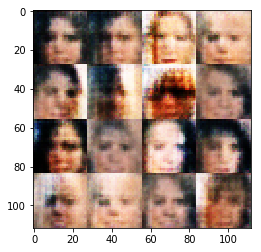

Epoch 1/1, batch 2210... Discriminator Loss: 1.3776... Generator Loss: 0.7611
Epoch 1/1, batch 2220... Discriminator Loss: 1.3763... Generator Loss: 0.8137
Epoch 1/1, batch 2230... Discriminator Loss: 1.4576... Generator Loss: 0.6788
Epoch 1/1, batch 2240... Discriminator Loss: 1.4066... Generator Loss: 0.7494
Epoch 1/1, batch 2250... Discriminator Loss: 1.4079... Generator Loss: 0.8628
Epoch 1/1, batch 2260... Discriminator Loss: 1.4054... Generator Loss: 0.8059
Epoch 1/1, batch 2270... Discriminator Loss: 1.4391... Generator Loss: 0.7817
Epoch 1/1, batch 2280... Discriminator Loss: 1.4027... Generator Loss: 0.8020
Epoch 1/1, batch 2290... Discriminator Loss: 1.4969... Generator Loss: 0.7261
Epoch 1/1, batch 2300... Discriminator Loss: 1.3960... Generator Loss: 0.7897


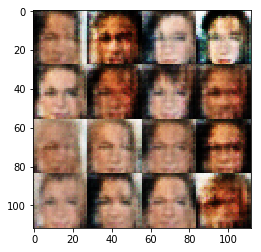

Epoch 1/1, batch 2310... Discriminator Loss: 1.4794... Generator Loss: 0.7937
Epoch 1/1, batch 2320... Discriminator Loss: 1.4276... Generator Loss: 0.7325
Epoch 1/1, batch 2330... Discriminator Loss: 1.4151... Generator Loss: 0.8105
Epoch 1/1, batch 2340... Discriminator Loss: 1.3847... Generator Loss: 0.7580
Epoch 1/1, batch 2350... Discriminator Loss: 1.4617... Generator Loss: 0.7340
Epoch 1/1, batch 2360... Discriminator Loss: 1.4279... Generator Loss: 0.8171
Epoch 1/1, batch 2370... Discriminator Loss: 1.4390... Generator Loss: 0.7370
Epoch 1/1, batch 2380... Discriminator Loss: 1.4428... Generator Loss: 0.7369
Epoch 1/1, batch 2390... Discriminator Loss: 1.4044... Generator Loss: 0.7576
Epoch 1/1, batch 2400... Discriminator Loss: 1.4643... Generator Loss: 0.7335


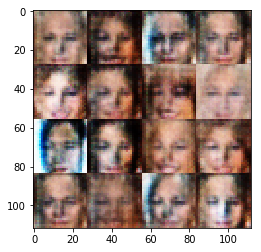

Epoch 1/1, batch 2410... Discriminator Loss: 1.3972... Generator Loss: 0.8389
Epoch 1/1, batch 2420... Discriminator Loss: 1.4191... Generator Loss: 0.7698
Epoch 1/1, batch 2430... Discriminator Loss: 1.4396... Generator Loss: 0.9073
Epoch 1/1, batch 2440... Discriminator Loss: 1.5279... Generator Loss: 0.6924
Epoch 1/1, batch 2450... Discriminator Loss: 1.4256... Generator Loss: 0.8213
Epoch 1/1, batch 2460... Discriminator Loss: 1.4253... Generator Loss: 0.7442
Epoch 1/1, batch 2470... Discriminator Loss: 1.4056... Generator Loss: 0.8884
Epoch 1/1, batch 2480... Discriminator Loss: 1.4206... Generator Loss: 0.7269
Epoch 1/1, batch 2490... Discriminator Loss: 1.3968... Generator Loss: 0.7432
Epoch 1/1, batch 2500... Discriminator Loss: 1.4456... Generator Loss: 0.7806


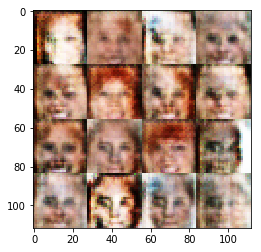

Epoch 1/1, batch 2510... Discriminator Loss: 1.4653... Generator Loss: 0.8009
Epoch 1/1, batch 2520... Discriminator Loss: 1.4472... Generator Loss: 0.7902
Epoch 1/1, batch 2530... Discriminator Loss: 1.4232... Generator Loss: 0.7587
Epoch 1/1, batch 2540... Discriminator Loss: 1.4118... Generator Loss: 0.7135
Epoch 1/1, batch 2550... Discriminator Loss: 1.4408... Generator Loss: 0.7969
Epoch 1/1, batch 2560... Discriminator Loss: 1.4423... Generator Loss: 0.7084
Epoch 1/1, batch 2570... Discriminator Loss: 1.4421... Generator Loss: 0.7841
Epoch 1/1, batch 2580... Discriminator Loss: 1.4113... Generator Loss: 0.7653
Epoch 1/1, batch 2590... Discriminator Loss: 1.4168... Generator Loss: 0.8522
Epoch 1/1, batch 2600... Discriminator Loss: 1.4578... Generator Loss: 0.6611


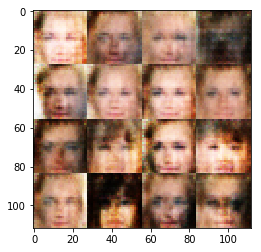

Epoch 1/1, batch 2610... Discriminator Loss: 1.4012... Generator Loss: 0.7988
Epoch 1/1, batch 2620... Discriminator Loss: 1.4099... Generator Loss: 0.6783
Epoch 1/1, batch 2630... Discriminator Loss: 1.3633... Generator Loss: 0.7883
Epoch 1/1, batch 2640... Discriminator Loss: 1.4092... Generator Loss: 0.7602
Epoch 1/1, batch 2650... Discriminator Loss: 1.4409... Generator Loss: 0.8352
Epoch 1/1, batch 2660... Discriminator Loss: 1.4185... Generator Loss: 0.7588
Epoch 1/1, batch 2670... Discriminator Loss: 1.4074... Generator Loss: 0.6996
Epoch 1/1, batch 2680... Discriminator Loss: 1.4233... Generator Loss: 0.7562
Epoch 1/1, batch 2690... Discriminator Loss: 1.3939... Generator Loss: 0.7392
Epoch 1/1, batch 2700... Discriminator Loss: 1.3922... Generator Loss: 0.7599


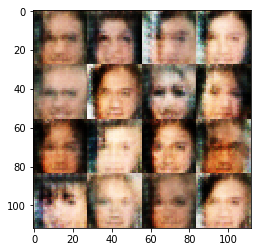

Epoch 1/1, batch 2710... Discriminator Loss: 1.4446... Generator Loss: 0.7767
Epoch 1/1, batch 2720... Discriminator Loss: 1.3910... Generator Loss: 0.7607
Epoch 1/1, batch 2730... Discriminator Loss: 1.4133... Generator Loss: 0.7483
Epoch 1/1, batch 2740... Discriminator Loss: 1.4156... Generator Loss: 0.8157
Epoch 1/1, batch 2750... Discriminator Loss: 1.4211... Generator Loss: 0.7790
Epoch 1/1, batch 2760... Discriminator Loss: 1.3957... Generator Loss: 0.7216
Epoch 1/1, batch 2770... Discriminator Loss: 1.4311... Generator Loss: 0.8205
Epoch 1/1, batch 2780... Discriminator Loss: 1.4616... Generator Loss: 0.7449
Epoch 1/1, batch 2790... Discriminator Loss: 1.4325... Generator Loss: 0.7963
Epoch 1/1, batch 2800... Discriminator Loss: 1.4045... Generator Loss: 0.8414


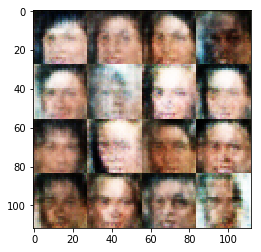

Epoch 1/1, batch 2810... Discriminator Loss: 1.3665... Generator Loss: 0.8977
Epoch 1/1, batch 2820... Discriminator Loss: 1.4130... Generator Loss: 0.7824
Epoch 1/1, batch 2830... Discriminator Loss: 1.4032... Generator Loss: 0.7557
Epoch 1/1, batch 2840... Discriminator Loss: 1.4410... Generator Loss: 0.7941
Epoch 1/1, batch 2850... Discriminator Loss: 1.3895... Generator Loss: 0.6882
Epoch 1/1, batch 2860... Discriminator Loss: 1.4175... Generator Loss: 0.8355
Epoch 1/1, batch 2870... Discriminator Loss: 1.4265... Generator Loss: 0.7620
Epoch 1/1, batch 2880... Discriminator Loss: 1.4330... Generator Loss: 0.6984
Epoch 1/1, batch 2890... Discriminator Loss: 1.4083... Generator Loss: 0.8634
Epoch 1/1, batch 2900... Discriminator Loss: 1.4120... Generator Loss: 0.8215


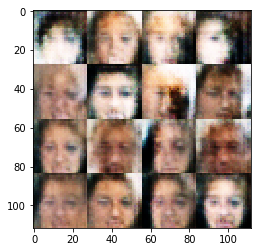

Epoch 1/1, batch 2910... Discriminator Loss: 1.4300... Generator Loss: 0.7906
Epoch 1/1, batch 2920... Discriminator Loss: 1.4294... Generator Loss: 0.8120
Epoch 1/1, batch 2930... Discriminator Loss: 1.4209... Generator Loss: 0.7833
Epoch 1/1, batch 2940... Discriminator Loss: 1.3736... Generator Loss: 0.7917
Epoch 1/1, batch 2950... Discriminator Loss: 1.4270... Generator Loss: 0.8350
Epoch 1/1, batch 2960... Discriminator Loss: 1.4528... Generator Loss: 0.7807
Epoch 1/1, batch 2970... Discriminator Loss: 1.4210... Generator Loss: 0.7823
Epoch 1/1, batch 2980... Discriminator Loss: 1.3854... Generator Loss: 0.7460
Epoch 1/1, batch 2990... Discriminator Loss: 1.4161... Generator Loss: 0.7638
Epoch 1/1, batch 3000... Discriminator Loss: 1.4029... Generator Loss: 0.7057


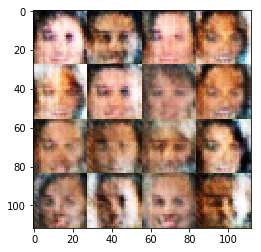

Epoch 1/1, batch 3010... Discriminator Loss: 1.4149... Generator Loss: 0.7430
Epoch 1/1, batch 3020... Discriminator Loss: 1.4441... Generator Loss: 0.8170
Epoch 1/1, batch 3030... Discriminator Loss: 1.4646... Generator Loss: 0.7695
Epoch 1/1, batch 3040... Discriminator Loss: 1.4150... Generator Loss: 0.7311
Epoch 1/1, batch 3050... Discriminator Loss: 1.4506... Generator Loss: 0.7858
Epoch 1/1, batch 3060... Discriminator Loss: 1.4115... Generator Loss: 0.8566
Epoch 1/1, batch 3070... Discriminator Loss: 1.3946... Generator Loss: 0.8135
Epoch 1/1, batch 3080... Discriminator Loss: 1.4314... Generator Loss: 0.7256
Epoch 1/1, batch 3090... Discriminator Loss: 1.4503... Generator Loss: 0.7542
Epoch 1/1, batch 3100... Discriminator Loss: 1.3757... Generator Loss: 0.7440


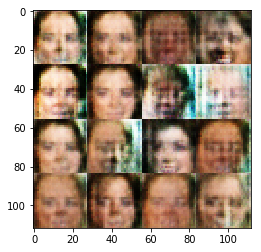

Epoch 1/1, batch 3110... Discriminator Loss: 1.3759... Generator Loss: 0.8094
Epoch 1/1, batch 3120... Discriminator Loss: 1.4079... Generator Loss: 0.7073
Epoch 1/1, batch 3130... Discriminator Loss: 1.3870... Generator Loss: 0.7657
Epoch 1/1, batch 3140... Discriminator Loss: 1.3765... Generator Loss: 0.7961
Epoch 1/1, batch 3150... Discriminator Loss: 1.4879... Generator Loss: 0.8861
Epoch 1/1, batch 3160... Discriminator Loss: 1.4267... Generator Loss: 0.8440
Epoch 1/1, batch 3170... Discriminator Loss: 1.4632... Generator Loss: 0.8908
Epoch 1/1, batch 3180... Discriminator Loss: 1.4320... Generator Loss: 0.7558
Epoch 1/1, batch 3190... Discriminator Loss: 1.4110... Generator Loss: 0.8684
Epoch 1/1, batch 3200... Discriminator Loss: 1.4016... Generator Loss: 0.7308


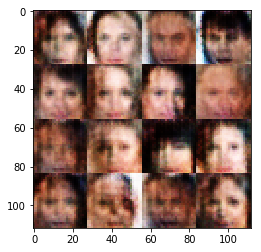

Epoch 1/1, batch 3210... Discriminator Loss: 1.4245... Generator Loss: 0.8381
Epoch 1/1, batch 3220... Discriminator Loss: 1.4105... Generator Loss: 0.7559
Epoch 1/1, batch 3230... Discriminator Loss: 1.4473... Generator Loss: 0.7370
Epoch 1/1, batch 3240... Discriminator Loss: 1.4154... Generator Loss: 0.7669
Epoch 1/1, batch 3250... Discriminator Loss: 1.3753... Generator Loss: 0.7203
Epoch 1/1, batch 3260... Discriminator Loss: 1.4235... Generator Loss: 0.7777
Epoch 1/1, batch 3270... Discriminator Loss: 1.4247... Generator Loss: 0.7766
Epoch 1/1, batch 3280... Discriminator Loss: 1.3922... Generator Loss: 0.7650
Epoch 1/1, batch 3290... Discriminator Loss: 1.4293... Generator Loss: 0.7043
Epoch 1/1, batch 3300... Discriminator Loss: 1.4134... Generator Loss: 0.7920


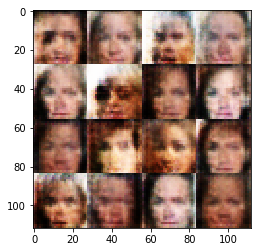

Epoch 1/1, batch 3310... Discriminator Loss: 1.3963... Generator Loss: 0.7963
Epoch 1/1, batch 3320... Discriminator Loss: 1.3966... Generator Loss: 0.8436
Epoch 1/1, batch 3330... Discriminator Loss: 1.4378... Generator Loss: 0.7718
Epoch 1/1, batch 3340... Discriminator Loss: 1.4165... Generator Loss: 0.7353
Epoch 1/1, batch 3350... Discriminator Loss: 1.4200... Generator Loss: 0.8673
Epoch 1/1, batch 3360... Discriminator Loss: 1.3817... Generator Loss: 0.7363
Epoch 1/1, batch 3370... Discriminator Loss: 1.3957... Generator Loss: 0.7842
Epoch 1/1, batch 3380... Discriminator Loss: 1.4182... Generator Loss: 0.7558
Epoch 1/1, batch 3390... Discriminator Loss: 1.3944... Generator Loss: 0.7925
Epoch 1/1, batch 3400... Discriminator Loss: 1.3973... Generator Loss: 0.7312


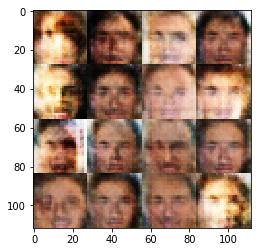

Epoch 1/1, batch 3410... Discriminator Loss: 1.4053... Generator Loss: 0.7568
Epoch 1/1, batch 3420... Discriminator Loss: 1.4367... Generator Loss: 0.7335
Epoch 1/1, batch 3430... Discriminator Loss: 1.4317... Generator Loss: 0.7567
Epoch 1/1, batch 3440... Discriminator Loss: 1.3859... Generator Loss: 0.7897
Epoch 1/1, batch 3450... Discriminator Loss: 1.4052... Generator Loss: 0.7720
Epoch 1/1, batch 3460... Discriminator Loss: 1.4222... Generator Loss: 0.7856
Epoch 1/1, batch 3470... Discriminator Loss: 1.3687... Generator Loss: 0.8177
Epoch 1/1, batch 3480... Discriminator Loss: 1.4367... Generator Loss: 0.7312
Epoch 1/1, batch 3490... Discriminator Loss: 1.4114... Generator Loss: 0.7301
Epoch 1/1, batch 3500... Discriminator Loss: 1.4373... Generator Loss: 0.8163


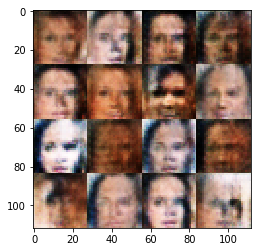

Epoch 1/1, batch 3510... Discriminator Loss: 1.4544... Generator Loss: 0.8267
Epoch 1/1, batch 3520... Discriminator Loss: 1.3506... Generator Loss: 0.7667
Epoch 1/1, batch 3530... Discriminator Loss: 1.4014... Generator Loss: 0.7981
Epoch 1/1, batch 3540... Discriminator Loss: 1.4123... Generator Loss: 0.8655
Epoch 1/1, batch 3550... Discriminator Loss: 1.4088... Generator Loss: 0.8335
Epoch 1/1, batch 3560... Discriminator Loss: 1.4149... Generator Loss: 0.7490
Epoch 1/1, batch 3570... Discriminator Loss: 1.4118... Generator Loss: 0.7408
Epoch 1/1, batch 3580... Discriminator Loss: 1.4070... Generator Loss: 0.7141
Epoch 1/1, batch 3590... Discriminator Loss: 1.4126... Generator Loss: 0.7512
Epoch 1/1, batch 3600... Discriminator Loss: 1.3900... Generator Loss: 0.8556


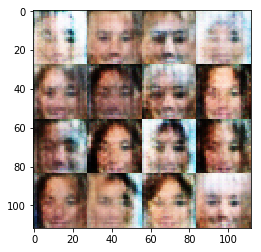

Epoch 1/1, batch 3610... Discriminator Loss: 1.4216... Generator Loss: 0.7566
Epoch 1/1, batch 3620... Discriminator Loss: 1.4127... Generator Loss: 0.7584
Epoch 1/1, batch 3630... Discriminator Loss: 1.3911... Generator Loss: 0.7333
Epoch 1/1, batch 3640... Discriminator Loss: 1.4024... Generator Loss: 0.7545
Epoch 1/1, batch 3650... Discriminator Loss: 1.4100... Generator Loss: 0.8046
Epoch 1/1, batch 3660... Discriminator Loss: 1.4394... Generator Loss: 0.8477
Epoch 1/1, batch 3670... Discriminator Loss: 1.4185... Generator Loss: 0.7913
Epoch 1/1, batch 3680... Discriminator Loss: 1.4328... Generator Loss: 0.6436
Epoch 1/1, batch 3690... Discriminator Loss: 1.4081... Generator Loss: 0.6578
Epoch 1/1, batch 3700... Discriminator Loss: 1.4282... Generator Loss: 0.7897


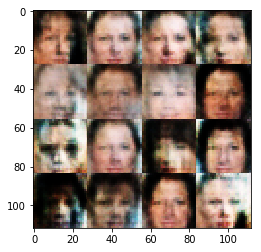

Epoch 1/1, batch 3710... Discriminator Loss: 1.4177... Generator Loss: 0.7204
Epoch 1/1, batch 3720... Discriminator Loss: 1.4001... Generator Loss: 0.7997
Epoch 1/1, batch 3730... Discriminator Loss: 1.4025... Generator Loss: 0.7778
Epoch 1/1, batch 3740... Discriminator Loss: 1.4316... Generator Loss: 0.8027
Epoch 1/1, batch 3750... Discriminator Loss: 1.4326... Generator Loss: 0.8128
Epoch 1/1, batch 3760... Discriminator Loss: 1.3930... Generator Loss: 0.7926
Epoch 1/1, batch 3770... Discriminator Loss: 1.4034... Generator Loss: 0.8027
Epoch 1/1, batch 3780... Discriminator Loss: 1.3845... Generator Loss: 0.7540
Epoch 1/1, batch 3790... Discriminator Loss: 1.3900... Generator Loss: 0.8134
Epoch 1/1, batch 3800... Discriminator Loss: 1.4045... Generator Loss: 0.7966


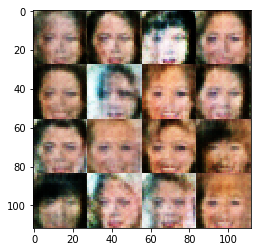

Epoch 1/1, batch 3810... Discriminator Loss: 1.4512... Generator Loss: 0.6627
Epoch 1/1, batch 3820... Discriminator Loss: 1.4491... Generator Loss: 0.7580
Epoch 1/1, batch 3830... Discriminator Loss: 1.4206... Generator Loss: 0.7155
Epoch 1/1, batch 3840... Discriminator Loss: 1.4228... Generator Loss: 0.7655
Epoch 1/1, batch 3850... Discriminator Loss: 1.3827... Generator Loss: 0.8459
Epoch 1/1, batch 3860... Discriminator Loss: 1.4256... Generator Loss: 0.7047
Epoch 1/1, batch 3870... Discriminator Loss: 1.4376... Generator Loss: 0.7034
Epoch 1/1, batch 3880... Discriminator Loss: 1.4231... Generator Loss: 0.7593
Epoch 1/1, batch 3890... Discriminator Loss: 1.3986... Generator Loss: 0.6407
Epoch 1/1, batch 3900... Discriminator Loss: 1.3953... Generator Loss: 0.7875


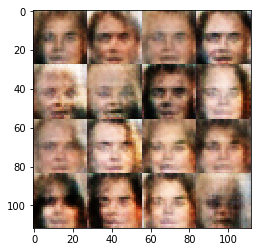

Epoch 1/1, batch 3910... Discriminator Loss: 1.4056... Generator Loss: 0.8504
Epoch 1/1, batch 3920... Discriminator Loss: 1.4205... Generator Loss: 0.7177
Epoch 1/1, batch 3930... Discriminator Loss: 1.4140... Generator Loss: 0.7672
Epoch 1/1, batch 3940... Discriminator Loss: 1.4121... Generator Loss: 0.7784
Epoch 1/1, batch 3950... Discriminator Loss: 1.4331... Generator Loss: 0.7501
Epoch 1/1, batch 3960... Discriminator Loss: 1.4050... Generator Loss: 0.6714
Epoch 1/1, batch 3970... Discriminator Loss: 1.4220... Generator Loss: 0.8041
Epoch 1/1, batch 3980... Discriminator Loss: 1.3968... Generator Loss: 0.7577
Epoch 1/1, batch 3990... Discriminator Loss: 1.4696... Generator Loss: 0.7664
Epoch 1/1, batch 4000... Discriminator Loss: 1.4102... Generator Loss: 0.7244


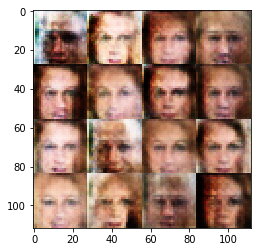

Epoch 1/1, batch 4010... Discriminator Loss: 1.4152... Generator Loss: 0.8272
Epoch 1/1, batch 4020... Discriminator Loss: 1.4129... Generator Loss: 0.7801
Epoch 1/1, batch 4030... Discriminator Loss: 1.3820... Generator Loss: 0.8854
Epoch 1/1, batch 4040... Discriminator Loss: 1.3701... Generator Loss: 0.7046
Epoch 1/1, batch 4050... Discriminator Loss: 1.4300... Generator Loss: 0.7874
Epoch 1/1, batch 4060... Discriminator Loss: 1.3808... Generator Loss: 0.7370
Epoch 1/1, batch 4070... Discriminator Loss: 1.3720... Generator Loss: 0.7710
Epoch 1/1, batch 4080... Discriminator Loss: 1.4551... Generator Loss: 0.7172
Epoch 1/1, batch 4090... Discriminator Loss: 1.4345... Generator Loss: 0.7448
Epoch 1/1, batch 4100... Discriminator Loss: 1.3903... Generator Loss: 0.7983


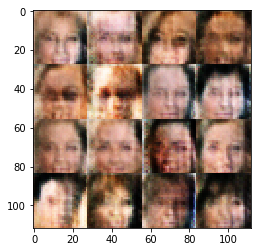

Epoch 1/1, batch 4110... Discriminator Loss: 1.4060... Generator Loss: 0.7080
Epoch 1/1, batch 4120... Discriminator Loss: 1.3847... Generator Loss: 0.7290
Epoch 1/1, batch 4130... Discriminator Loss: 1.4246... Generator Loss: 0.8068
Epoch 1/1, batch 4140... Discriminator Loss: 1.3855... Generator Loss: 0.8605
Epoch 1/1, batch 4150... Discriminator Loss: 1.3747... Generator Loss: 0.7662
Epoch 1/1, batch 4160... Discriminator Loss: 1.4461... Generator Loss: 0.6886
Epoch 1/1, batch 4170... Discriminator Loss: 1.4287... Generator Loss: 0.7540
Epoch 1/1, batch 4180... Discriminator Loss: 1.4150... Generator Loss: 0.6806
Epoch 1/1, batch 4190... Discriminator Loss: 1.3920... Generator Loss: 0.7556
Epoch 1/1, batch 4200... Discriminator Loss: 1.3857... Generator Loss: 0.7610


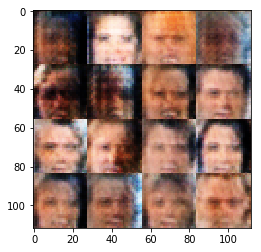

Epoch 1/1, batch 4210... Discriminator Loss: 1.3878... Generator Loss: 0.7746
Epoch 1/1, batch 4220... Discriminator Loss: 1.4005... Generator Loss: 0.7693
Epoch 1/1, batch 4230... Discriminator Loss: 1.3560... Generator Loss: 0.7902
Epoch 1/1, batch 4240... Discriminator Loss: 1.4168... Generator Loss: 0.7699
Epoch 1/1, batch 4250... Discriminator Loss: 1.4088... Generator Loss: 0.8305
Epoch 1/1, batch 4260... Discriminator Loss: 1.4039... Generator Loss: 0.7553
Epoch 1/1, batch 4270... Discriminator Loss: 1.4005... Generator Loss: 0.7770
Epoch 1/1, batch 4280... Discriminator Loss: 1.3752... Generator Loss: 0.8571
Epoch 1/1, batch 4290... Discriminator Loss: 1.4073... Generator Loss: 0.8290
Epoch 1/1, batch 4300... Discriminator Loss: 1.4374... Generator Loss: 0.8063


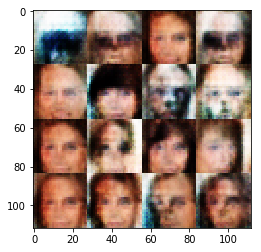

Epoch 1/1, batch 4310... Discriminator Loss: 1.4220... Generator Loss: 0.8323
Epoch 1/1, batch 4320... Discriminator Loss: 1.4112... Generator Loss: 0.7983
Epoch 1/1, batch 4330... Discriminator Loss: 1.4173... Generator Loss: 0.7396
Epoch 1/1, batch 4340... Discriminator Loss: 1.4103... Generator Loss: 0.7039
Epoch 1/1, batch 4350... Discriminator Loss: 1.4411... Generator Loss: 0.7193
Epoch 1/1, batch 4360... Discriminator Loss: 1.3778... Generator Loss: 0.6805
Epoch 1/1, batch 4370... Discriminator Loss: 1.4000... Generator Loss: 0.7641
Epoch 1/1, batch 4380... Discriminator Loss: 1.4070... Generator Loss: 0.8200
Epoch 1/1, batch 4390... Discriminator Loss: 1.4005... Generator Loss: 0.7806
Epoch 1/1, batch 4400... Discriminator Loss: 1.4197... Generator Loss: 0.7860


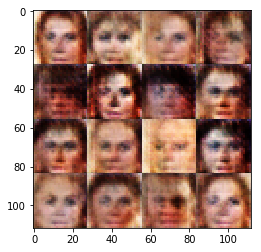

Epoch 1/1, batch 4410... Discriminator Loss: 1.4409... Generator Loss: 0.9061
Epoch 1/1, batch 4420... Discriminator Loss: 1.3856... Generator Loss: 0.6821
Epoch 1/1, batch 4430... Discriminator Loss: 1.4006... Generator Loss: 0.7813
Epoch 1/1, batch 4440... Discriminator Loss: 1.3880... Generator Loss: 0.6952
Epoch 1/1, batch 4450... Discriminator Loss: 1.3858... Generator Loss: 0.7932
Epoch 1/1, batch 4460... Discriminator Loss: 1.3989... Generator Loss: 0.7759
Epoch 1/1, batch 4470... Discriminator Loss: 1.4047... Generator Loss: 0.8155
Epoch 1/1, batch 4480... Discriminator Loss: 1.4392... Generator Loss: 0.7423
Epoch 1/1, batch 4490... Discriminator Loss: 1.4016... Generator Loss: 0.7897
Epoch 1/1, batch 4500... Discriminator Loss: 1.3874... Generator Loss: 0.8464


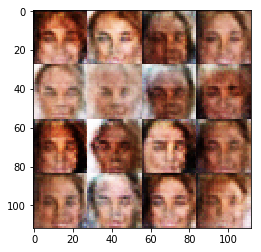

Epoch 1/1, batch 4510... Discriminator Loss: 1.3866... Generator Loss: 0.7417
Epoch 1/1, batch 4520... Discriminator Loss: 1.3920... Generator Loss: 0.7650
Epoch 1/1, batch 4530... Discriminator Loss: 1.4226... Generator Loss: 0.7290
Epoch 1/1, batch 4540... Discriminator Loss: 1.4021... Generator Loss: 0.7088
Epoch 1/1, batch 4550... Discriminator Loss: 1.4199... Generator Loss: 0.8991
Epoch 1/1, batch 4560... Discriminator Loss: 1.4494... Generator Loss: 0.7558
Epoch 1/1, batch 4570... Discriminator Loss: 1.3561... Generator Loss: 0.8040
Epoch 1/1, batch 4580... Discriminator Loss: 1.4048... Generator Loss: 0.8017
Epoch 1/1, batch 4590... Discriminator Loss: 1.4676... Generator Loss: 0.7608
Epoch 1/1, batch 4600... Discriminator Loss: 1.4202... Generator Loss: 0.7138


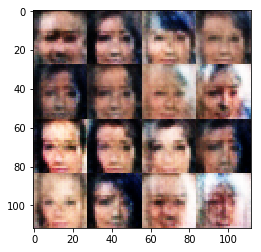

Epoch 1/1, batch 4610... Discriminator Loss: 1.3860... Generator Loss: 0.7371
Epoch 1/1, batch 4620... Discriminator Loss: 1.3900... Generator Loss: 0.7719
Epoch 1/1, batch 4630... Discriminator Loss: 1.3683... Generator Loss: 0.7733
Epoch 1/1, batch 4640... Discriminator Loss: 1.4110... Generator Loss: 0.7665
Epoch 1/1, batch 4650... Discriminator Loss: 1.4034... Generator Loss: 0.8103
Epoch 1/1, batch 4660... Discriminator Loss: 1.4174... Generator Loss: 0.6831
Epoch 1/1, batch 4670... Discriminator Loss: 1.4026... Generator Loss: 0.7495
Epoch 1/1, batch 4680... Discriminator Loss: 1.4091... Generator Loss: 0.7842
Epoch 1/1, batch 4690... Discriminator Loss: 1.3890... Generator Loss: 0.8378
Epoch 1/1, batch 4700... Discriminator Loss: 1.4182... Generator Loss: 0.6897


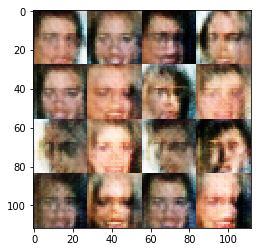

Epoch 1/1, batch 4710... Discriminator Loss: 1.4221... Generator Loss: 0.7919
Epoch 1/1, batch 4720... Discriminator Loss: 1.4032... Generator Loss: 0.8674
Epoch 1/1, batch 4730... Discriminator Loss: 1.4322... Generator Loss: 0.7838
Epoch 1/1, batch 4740... Discriminator Loss: 1.4136... Generator Loss: 0.7700
Epoch 1/1, batch 4750... Discriminator Loss: 1.4185... Generator Loss: 0.6540
Epoch 1/1, batch 4760... Discriminator Loss: 1.3822... Generator Loss: 0.8224
Epoch 1/1, batch 4770... Discriminator Loss: 1.3829... Generator Loss: 0.8441
Epoch 1/1, batch 4780... Discriminator Loss: 1.4389... Generator Loss: 0.6841
Epoch 1/1, batch 4790... Discriminator Loss: 1.4141... Generator Loss: 0.7808
Epoch 1/1, batch 4800... Discriminator Loss: 1.4006... Generator Loss: 0.6697


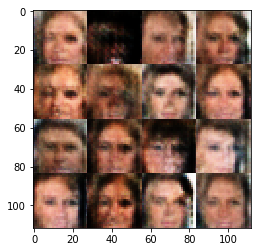

Epoch 1/1, batch 4810... Discriminator Loss: 1.4031... Generator Loss: 0.8636
Epoch 1/1, batch 4820... Discriminator Loss: 1.4103... Generator Loss: 0.7764
Epoch 1/1, batch 4830... Discriminator Loss: 1.4031... Generator Loss: 0.8838
Epoch 1/1, batch 4840... Discriminator Loss: 1.4333... Generator Loss: 0.7716
Epoch 1/1, batch 4850... Discriminator Loss: 1.3876... Generator Loss: 0.7956
Epoch 1/1, batch 4860... Discriminator Loss: 1.4206... Generator Loss: 0.8551
Epoch 1/1, batch 4870... Discriminator Loss: 1.3815... Generator Loss: 0.6997
Epoch 1/1, batch 4880... Discriminator Loss: 1.4135... Generator Loss: 0.7677
Epoch 1/1, batch 4890... Discriminator Loss: 1.3772... Generator Loss: 0.7846
Epoch 1/1, batch 4900... Discriminator Loss: 1.4214... Generator Loss: 0.7409


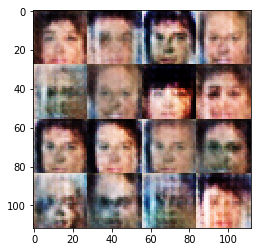

Epoch 1/1, batch 4910... Discriminator Loss: 1.4132... Generator Loss: 0.6935
Epoch 1/1, batch 4920... Discriminator Loss: 1.4110... Generator Loss: 0.7471
Epoch 1/1, batch 4930... Discriminator Loss: 1.4060... Generator Loss: 0.7412
Epoch 1/1, batch 4940... Discriminator Loss: 1.4085... Generator Loss: 0.7791
Epoch 1/1, batch 4950... Discriminator Loss: 1.4122... Generator Loss: 0.8632
Epoch 1/1, batch 4960... Discriminator Loss: 1.3825... Generator Loss: 0.7455
Epoch 1/1, batch 4970... Discriminator Loss: 1.3981... Generator Loss: 0.8034
Epoch 1/1, batch 4980... Discriminator Loss: 1.4151... Generator Loss: 0.7900
Epoch 1/1, batch 4990... Discriminator Loss: 1.4126... Generator Loss: 0.6988
Epoch 1/1, batch 5000... Discriminator Loss: 1.4155... Generator Loss: 0.7306


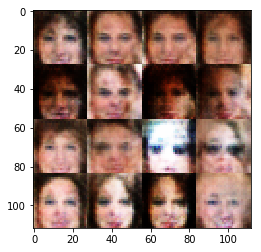

Epoch 1/1, batch 5010... Discriminator Loss: 1.4132... Generator Loss: 0.8588
Epoch 1/1, batch 5020... Discriminator Loss: 1.4208... Generator Loss: 0.8014
Epoch 1/1, batch 5030... Discriminator Loss: 1.4177... Generator Loss: 0.8211
Epoch 1/1, batch 5040... Discriminator Loss: 1.4069... Generator Loss: 0.7451
Epoch 1/1, batch 5050... Discriminator Loss: 1.4143... Generator Loss: 0.7421
Epoch 1/1, batch 5060... Discriminator Loss: 1.4185... Generator Loss: 0.9115
Epoch 1/1, batch 5070... Discriminator Loss: 1.4263... Generator Loss: 0.7913
Epoch 1/1, batch 5080... Discriminator Loss: 1.4331... Generator Loss: 0.7602
Epoch 1/1, batch 5090... Discriminator Loss: 1.4361... Generator Loss: 0.7369
Epoch 1/1, batch 5100... Discriminator Loss: 1.4010... Generator Loss: 0.7318


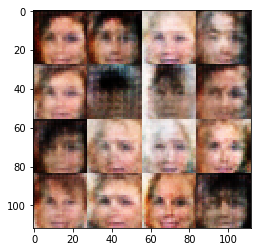

Epoch 1/1, batch 5110... Discriminator Loss: 1.4091... Generator Loss: 0.7645
Epoch 1/1, batch 5120... Discriminator Loss: 1.3977... Generator Loss: 0.7196
Epoch 1/1, batch 5130... Discriminator Loss: 1.4394... Generator Loss: 0.8950
Epoch 1/1, batch 5140... Discriminator Loss: 1.4177... Generator Loss: 0.7190
Epoch 1/1, batch 5150... Discriminator Loss: 1.4190... Generator Loss: 0.8222
Epoch 1/1, batch 5160... Discriminator Loss: 1.4184... Generator Loss: 0.7730
Epoch 1/1, batch 5170... Discriminator Loss: 1.3958... Generator Loss: 0.7604
Epoch 1/1, batch 5180... Discriminator Loss: 1.3864... Generator Loss: 0.8223
Epoch 1/1, batch 5190... Discriminator Loss: 1.3899... Generator Loss: 0.7509
Epoch 1/1, batch 5200... Discriminator Loss: 1.4176... Generator Loss: 0.6901


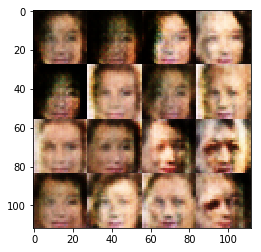

Epoch 1/1, batch 5210... Discriminator Loss: 1.4235... Generator Loss: 0.6615
Epoch 1/1, batch 5220... Discriminator Loss: 1.4144... Generator Loss: 0.7470
Epoch 1/1, batch 5230... Discriminator Loss: 1.4024... Generator Loss: 0.7312
Epoch 1/1, batch 5240... Discriminator Loss: 1.4220... Generator Loss: 0.7505
Epoch 1/1, batch 5250... Discriminator Loss: 1.4249... Generator Loss: 0.8684
Epoch 1/1, batch 5260... Discriminator Loss: 1.3687... Generator Loss: 0.8339
Epoch 1/1, batch 5270... Discriminator Loss: 1.4273... Generator Loss: 0.8871
Epoch 1/1, batch 5280... Discriminator Loss: 1.3881... Generator Loss: 0.8334
Epoch 1/1, batch 5290... Discriminator Loss: 1.3826... Generator Loss: 0.8682
Epoch 1/1, batch 5300... Discriminator Loss: 1.3868... Generator Loss: 0.7308


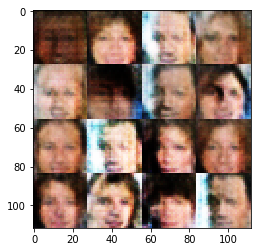

Epoch 1/1, batch 5310... Discriminator Loss: 1.4076... Generator Loss: 0.8421
Epoch 1/1, batch 5320... Discriminator Loss: 1.4124... Generator Loss: 0.8710
Epoch 1/1, batch 5330... Discriminator Loss: 1.3820... Generator Loss: 0.8257
Epoch 1/1, batch 5340... Discriminator Loss: 1.3980... Generator Loss: 0.7870
Epoch 1/1, batch 5350... Discriminator Loss: 1.4514... Generator Loss: 0.6122
Epoch 1/1, batch 5360... Discriminator Loss: 1.4008... Generator Loss: 0.6543
Epoch 1/1, batch 5370... Discriminator Loss: 1.4000... Generator Loss: 0.7171
Epoch 1/1, batch 5380... Discriminator Loss: 1.4138... Generator Loss: 0.8657
Epoch 1/1, batch 5390... Discriminator Loss: 1.4037... Generator Loss: 0.6545
Epoch 1/1, batch 5400... Discriminator Loss: 1.4084... Generator Loss: 0.9434


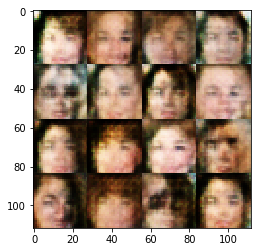

Epoch 1/1, batch 5410... Discriminator Loss: 1.4305... Generator Loss: 0.7069
Epoch 1/1, batch 5420... Discriminator Loss: 1.4107... Generator Loss: 0.8235
Epoch 1/1, batch 5430... Discriminator Loss: 1.4039... Generator Loss: 0.7682
Epoch 1/1, batch 5440... Discriminator Loss: 1.4244... Generator Loss: 0.8319
Epoch 1/1, batch 5450... Discriminator Loss: 1.4071... Generator Loss: 0.6719
Epoch 1/1, batch 5460... Discriminator Loss: 1.4028... Generator Loss: 0.6716
Epoch 1/1, batch 5470... Discriminator Loss: 1.3909... Generator Loss: 0.7829
Epoch 1/1, batch 5480... Discriminator Loss: 1.3905... Generator Loss: 0.7076
Epoch 1/1, batch 5490... Discriminator Loss: 1.4023... Generator Loss: 0.8215
Epoch 1/1, batch 5500... Discriminator Loss: 1.4133... Generator Loss: 0.7734


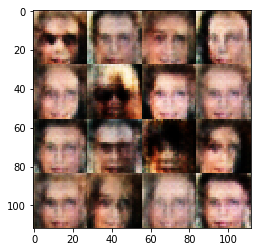

Epoch 1/1, batch 5510... Discriminator Loss: 1.4053... Generator Loss: 0.7765
Epoch 1/1, batch 5520... Discriminator Loss: 1.4004... Generator Loss: 0.8150
Epoch 1/1, batch 5530... Discriminator Loss: 1.3968... Generator Loss: 0.6854
Epoch 1/1, batch 5540... Discriminator Loss: 1.3945... Generator Loss: 0.7789
Epoch 1/1, batch 5550... Discriminator Loss: 1.3757... Generator Loss: 0.8266
Epoch 1/1, batch 5560... Discriminator Loss: 1.4095... Generator Loss: 0.7539
Epoch 1/1, batch 5570... Discriminator Loss: 1.4362... Generator Loss: 0.6396
Epoch 1/1, batch 5580... Discriminator Loss: 1.4419... Generator Loss: 0.7812
Epoch 1/1, batch 5590... Discriminator Loss: 1.4274... Generator Loss: 0.7257
Epoch 1/1, batch 5600... Discriminator Loss: 1.4834... Generator Loss: 0.7344


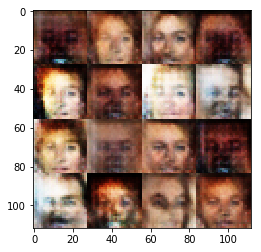

Epoch 1/1, batch 5610... Discriminator Loss: 1.4603... Generator Loss: 0.6588
Epoch 1/1, batch 5620... Discriminator Loss: 1.4210... Generator Loss: 0.7360
Epoch 1/1, batch 5630... Discriminator Loss: 1.3932... Generator Loss: 0.7503
Epoch 1/1, batch 5640... Discriminator Loss: 1.3926... Generator Loss: 0.7863
Epoch 1/1, batch 5650... Discriminator Loss: 1.4301... Generator Loss: 0.7506
Epoch 1/1, batch 5660... Discriminator Loss: 1.3901... Generator Loss: 0.7023
Epoch 1/1, batch 5670... Discriminator Loss: 1.3911... Generator Loss: 0.7149
Epoch 1/1, batch 5680... Discriminator Loss: 1.4497... Generator Loss: 0.7426
Epoch 1/1, batch 5690... Discriminator Loss: 1.4112... Generator Loss: 0.8555
Epoch 1/1, batch 5700... Discriminator Loss: 1.4098... Generator Loss: 0.7475


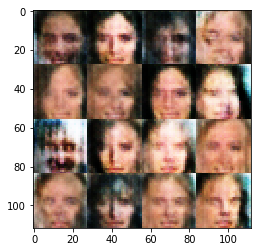

Epoch 1/1, batch 5710... Discriminator Loss: 1.4007... Generator Loss: 0.7325
Epoch 1/1, batch 5720... Discriminator Loss: 1.3921... Generator Loss: 0.7541
Epoch 1/1, batch 5730... Discriminator Loss: 1.4191... Generator Loss: 0.7846
Epoch 1/1, batch 5740... Discriminator Loss: 1.3503... Generator Loss: 0.8305
Epoch 1/1, batch 5750... Discriminator Loss: 1.4079... Generator Loss: 0.7699
Epoch 1/1, batch 5760... Discriminator Loss: 1.3891... Generator Loss: 0.8303
Epoch 1/1, batch 5770... Discriminator Loss: 1.4249... Generator Loss: 0.7666
Epoch 1/1, batch 5780... Discriminator Loss: 1.4163... Generator Loss: 0.8094
Epoch 1/1, batch 5790... Discriminator Loss: 1.4145... Generator Loss: 0.8612
Epoch 1/1, batch 5800... Discriminator Loss: 1.4097... Generator Loss: 0.8310


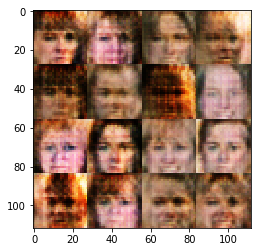

Epoch 1/1, batch 5810... Discriminator Loss: 1.3905... Generator Loss: 0.7936
Epoch 1/1, batch 5820... Discriminator Loss: 1.4153... Generator Loss: 0.7264
Epoch 1/1, batch 5830... Discriminator Loss: 1.4063... Generator Loss: 0.8804
Epoch 1/1, batch 5840... Discriminator Loss: 1.3958... Generator Loss: 0.8085
Epoch 1/1, batch 5850... Discriminator Loss: 1.3958... Generator Loss: 0.8103
Epoch 1/1, batch 5860... Discriminator Loss: 1.3933... Generator Loss: 0.7402
Epoch 1/1, batch 5870... Discriminator Loss: 1.4104... Generator Loss: 0.7323
Epoch 1/1, batch 5880... Discriminator Loss: 1.3862... Generator Loss: 0.7712
Epoch 1/1, batch 5890... Discriminator Loss: 1.4188... Generator Loss: 0.6971
Epoch 1/1, batch 5900... Discriminator Loss: 1.3929... Generator Loss: 0.7550


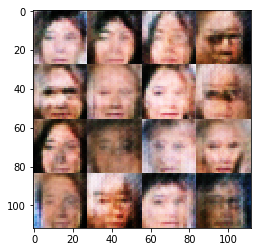

Epoch 1/1, batch 5910... Discriminator Loss: 1.4240... Generator Loss: 0.8681
Epoch 1/1, batch 5920... Discriminator Loss: 1.4071... Generator Loss: 0.7181
Epoch 1/1, batch 5930... Discriminator Loss: 1.4081... Generator Loss: 0.7477
Epoch 1/1, batch 5940... Discriminator Loss: 1.4026... Generator Loss: 0.8493
Epoch 1/1, batch 5950... Discriminator Loss: 1.4130... Generator Loss: 0.8577
Epoch 1/1, batch 5960... Discriminator Loss: 1.3736... Generator Loss: 0.8349
Epoch 1/1, batch 5970... Discriminator Loss: 1.4050... Generator Loss: 0.8973
Epoch 1/1, batch 5980... Discriminator Loss: 1.3933... Generator Loss: 0.8362
Epoch 1/1, batch 5990... Discriminator Loss: 1.4082... Generator Loss: 0.6818
Epoch 1/1, batch 6000... Discriminator Loss: 1.3634... Generator Loss: 0.8321


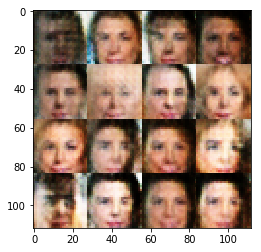

Epoch 1/1, batch 6010... Discriminator Loss: 1.3875... Generator Loss: 0.7511
Epoch 1/1, batch 6020... Discriminator Loss: 1.4065... Generator Loss: 0.8698
Epoch 1/1, batch 6030... Discriminator Loss: 1.4266... Generator Loss: 0.6811
Epoch 1/1, batch 6040... Discriminator Loss: 1.3876... Generator Loss: 0.7363
Epoch 1/1, batch 6050... Discriminator Loss: 1.4032... Generator Loss: 0.8678
Epoch 1/1, batch 6060... Discriminator Loss: 1.4094... Generator Loss: 0.7173
Epoch 1/1, batch 6070... Discriminator Loss: 1.4227... Generator Loss: 0.7344
Epoch 1/1, batch 6080... Discriminator Loss: 1.4182... Generator Loss: 0.7901
Epoch 1/1, batch 6090... Discriminator Loss: 1.4201... Generator Loss: 0.8586
Epoch 1/1, batch 6100... Discriminator Loss: 1.4343... Generator Loss: 0.8096


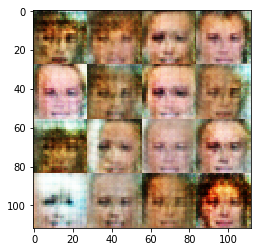

Epoch 1/1, batch 6110... Discriminator Loss: 1.4184... Generator Loss: 0.7138
Epoch 1/1, batch 6120... Discriminator Loss: 1.3856... Generator Loss: 0.8328
Epoch 1/1, batch 6130... Discriminator Loss: 1.3807... Generator Loss: 0.8276
Epoch 1/1, batch 6140... Discriminator Loss: 1.3866... Generator Loss: 0.7833
Epoch 1/1, batch 6150... Discriminator Loss: 1.3963... Generator Loss: 0.7557
Epoch 1/1, batch 6160... Discriminator Loss: 1.3884... Generator Loss: 0.8435
Epoch 1/1, batch 6170... Discriminator Loss: 1.4151... Generator Loss: 0.6801
Epoch 1/1, batch 6180... Discriminator Loss: 1.3918... Generator Loss: 0.7513
Epoch 1/1, batch 6190... Discriminator Loss: 1.3700... Generator Loss: 0.7492
Epoch 1/1, batch 6200... Discriminator Loss: 1.3982... Generator Loss: 0.7571


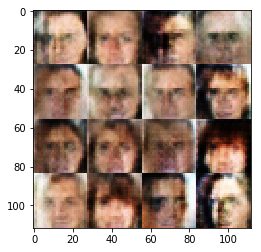

Epoch 1/1, batch 6210... Discriminator Loss: 1.4184... Generator Loss: 0.6735
Epoch 1/1, batch 6220... Discriminator Loss: 1.3775... Generator Loss: 0.7817
Epoch 1/1, batch 6230... Discriminator Loss: 1.4178... Generator Loss: 0.8223
Epoch 1/1, batch 6240... Discriminator Loss: 1.3825... Generator Loss: 0.8069
Epoch 1/1, batch 6250... Discriminator Loss: 1.3964... Generator Loss: 0.8003
Epoch 1/1, batch 6260... Discriminator Loss: 1.3844... Generator Loss: 0.7405
Epoch 1/1, batch 6270... Discriminator Loss: 1.3942... Generator Loss: 0.7637
Epoch 1/1, batch 6280... Discriminator Loss: 1.4419... Generator Loss: 0.7028
Epoch 1/1, batch 6290... Discriminator Loss: 1.4102... Generator Loss: 0.8105
Epoch 1/1, batch 6300... Discriminator Loss: 1.3743... Generator Loss: 0.7763


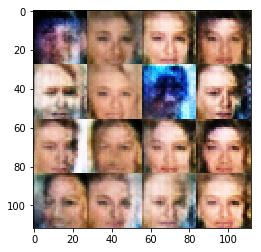

Epoch 1/1, batch 6310... Discriminator Loss: 1.4271... Generator Loss: 0.8520
Epoch 1/1, batch 6320... Discriminator Loss: 1.4035... Generator Loss: 0.7739
Epoch 1/1, batch 6330... Discriminator Loss: 1.3997... Generator Loss: 0.8492


In [99]:
batch_size = 32
z_dim = 200
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.